# Assignment 2
**Group 5**

Group members:
- Moqian Chen (r0965473)
- Laurens Dergent (r0794288)
- Sarah Guilliams (r0751825)
- Yeabsera Kinfu (r0930148)
- Jorge Puertolas Molina (r0978889)
- Isabel Scholz (r1008561)

Link to the GitHub repository: https://github.com/LaurensDergent/DataAnalytics.git


In assignment 2, we will use the screenshots of a video game to predict its price. As seen in the lectures, pretrained convolutional neural networks (CNNs) can be utilized to make these predictions.

To begin, the essential packages and data are loaded. Additionally, a local path is established to access the stored images on the device.

In [5]:
#Load the following packages:
import os
import json
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn import metrics

In [2]:
# Set the location of where the images are stored. Adjust to the correct location when running the code depending on the methodology that will be used.

# For Methodology 1 and 2
image_location = '/Users/sarahguilliams/Desktop/Advanced Analytics in a Big Data World/Assignment2/images'
# For Methodology 3
#image_location = 'D:/images/stitched'

#  Load the json datafile
file_path = "dataset.json"

# Open the JSON file and load its contents
with open(file_path, 'r') as file:
    data = json.load(file)

data1 = pd.DataFrame(data) #Transform to a DataFrame
data1.head() 

appid     release                             title  price sentiment  \
0  2805630  2024-02-24                         BotMobile   1173  Positive   
1  2805610  2024-02-24  Just skill shooter 3: 2d edition    199  Positive   
2  2816420  2024-02-24                        Slime Drop    199      None   
3  2815670  2024-02-24               Path to the Creator    299      None   
4  2776190  2024-02-24                  Crowd Control VR   1179      None   

  reviews percentage                                               tags  \
0      10        100  [Action, Action-Adventure, Adventure, Casual, ...   
1      11         90  [2D, Action, Action RPG, Action-Adventure, Adv...   
2    None        NaN  [2D, Arcade, Casual, Clicker, Colorful, Cute, ...   
3    None        NaN  [2D, Action RPG, Adventure, Character Customiz...   
4    None        NaN  [360 Video, Arcade, Cartoony, Casual, Fantasy,...   

                                         screenshots  
0  [2805630_ss_02b69bffacf19807fb6202fb8167fad7e0...  
1  [2805610_ss_21f5dfd4d369f1cefdd9d233f574a4758d...  
2  [2816420_ss_649a6c5bb66b93bf7b0a384d412923618d...  
3  [2815670_ss_06c8a39fd0618390bdedaff037f2463ca4...  
4  [2776190_ss_01d6152f8e559e051312ea5e6232ba1ecb...

For this assignment, we use the above dataframe, which contains the prices (in ¢) and the corresponding screenshots for each game. Since each game has multiple available images, we explored different approaches when fitting and evaluating our CNNs. One approach ignores the fact that images belong to the same game, while the others keep the screenshots from each game together, providing multiple screenshots as input to the model. This led us to develop three distinct CNNs:

1. A CNN that does not consider that screenshots belong to the same game.

1. A CNN that acknowledges that some screenshots belong to the same game by using multiple screenshots as inputs of a multi-input CNN with a concatenated layer.

1. A CNN that considers that some screenshots belong to the same game by stitching the screenshots together to create one large image. This large image is then used as a single input to the CNN.

Each method will be discussed in this assignment, including the insights gained during their implementation. Note that some steps were repeated across methods; thus, these steps will be detailed in the first method and only referenced in the subsequent methods.

This assignment is structured as follows: First, general preprocessing steps are discussed which are applied to all three methods. Next, we detail the preprocessing steps specific to each method. Following this, we develop each model along with the necessary evaluation criteria. Based on the evaluation metrics, we select the best of the three proposed methods. Lastly, we apply an interpretability technique to gain insights into the CNNs.

## 1. General Preprocessing
This section covers the initial general preprocessing steps performed before implementing each methodology. Additionally, methodology-specific preprocessing steps were carried out before each methodology, which will be elaborated on in their respective sections.

### 1.1 Exploratory Data Analysis
During the development of the methodologies, we encountered a significant challenge due to the size of the dataset, totaling to more than 125,000 images. That is why, during the development stage, we initially worked with smaller subsets of the dataset. We would select a percentage of games within this subset on which the subsequent steps were performed. Initially, only 10\% of the dataset was selected until we successfully executed the models without errors. Subsequently, we extended our analysis to include all games, hence the selection of all games at this stage.

In [3]:
num_selected_games = int(len(data1)*1) # Select a portion of the games. If we want to train on all of the data, set it equal to 1.
np.random.seed(0) # This is so that we get the same games each time when training the model.
selected_games = data1.sample(n=num_selected_games) # Select a random sample

The initial models that we fitted displayed very large error rates, with a Mean Absolute Error of around 1500. These large errors combined with the inability to sufficiently reduce them, prompted us to perform some additional exploratory data analysis of the game prices. In the boxplot below, we notice that there are some very large outliers, with game prices even reaching 500,000¢ (5,000 USD). Further analysis was conducted on these expensive games by examining them on the Steam Store (https://store.steampowered.com/). The game prices included in our dataset are the prices of the bundles that the games are included in. These bundles can contain multiple games or they can be an expansion pack. Hence, while the input (screenshots) depicts the original game, the corresponding price (output) is inaccurate. Due to these inaccuracies in the data, we made the decision to remove all games with a price above 10,000¢ (100 USD). Consequently, 0.517\% of the games were removed from the dataset.

In case we want our model to predict the prices of these bundles, we would first need to price all games included in this bundle based on screenshots and then sum these prices.

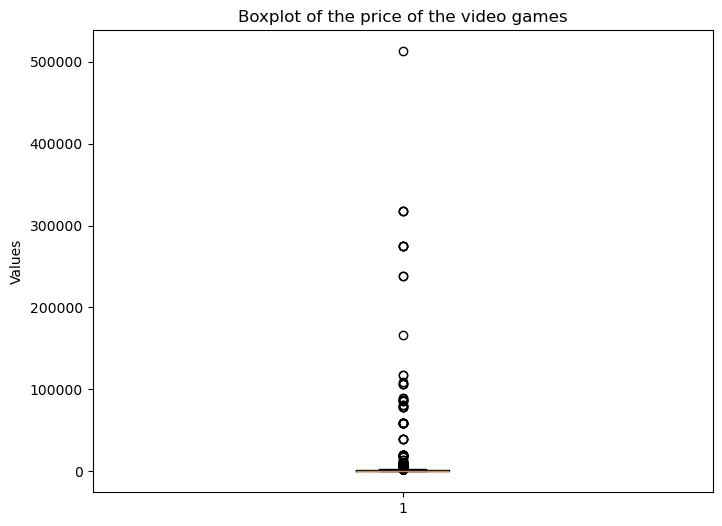

Q1:  199.0 Q2:  499.0 Q3:  998.0 Q4:  5999.0


In [4]:
#Make a boxplot of the feature 'price'
feature_data = selected_games['price']

# Create a boxplot using matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(feature_data)
plt.title('Boxplot of the price of the video games')
plt.ylabel('Values')
plt.show()

#calculate some quantiles
Q1 = feature_data.quantile(0.25)
Q2 = feature_data.quantile(0.50)
Q3 = feature_data.quantile(0.75)
Q4 = feature_data.quantile(0.99)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

print('Q1: ', Q1, 'Q2: ', Q2, 'Q3: ', Q3, 'Q4: ', Q4)
#Based on these quantiles its clear that some of these outliers can be taken out.

In [5]:
# Remove the games that have a price larger than 10000¢ from selected games
selected_games_no_outliers = selected_games[selected_games['price'] <= 10000] # Note, that we are working in cents!

Next, we plotted a boxplot and histogram to assess the distribution of the game prices in our final dataset. These visualizations reveal that most games are priced below 1000¢ (10 USD). However, the distribution is right-skewed, with some games still containing relatively high prices (e.g., above 2000¢).

We attempted a methodology involving the removal of 'high'-priced games from the training set, by splitting the data into games priced higher and lower than 2000¢. Subsequently, we randomly removed 50% of the games priced above 2000¢ to allow the model to focus on fitting the lower-priced games more effectively. Unfortunately, this additional preprocessing step did not improve the results of our models.

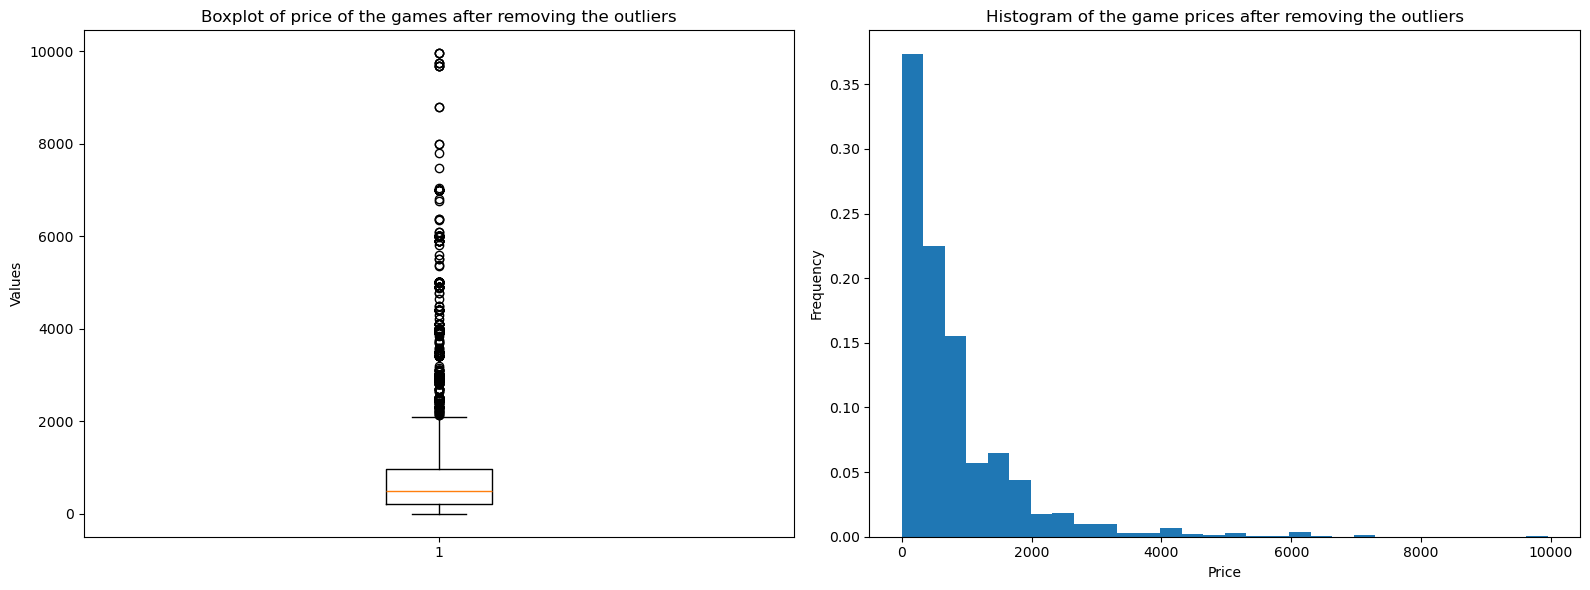

In [6]:
# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# First subplot: Boxplot of the games without the outliers
ax[0].boxplot(selected_games_no_outliers["price"])
ax[0].set_title('Boxplot of price of the games after removing the outliers')
ax[0].set_ylabel('Values')

# Second subplot: Histogram
# Multiply y-axis values by 100 to represent percentages
ax[1].hist(selected_games_no_outliers['price'], weights=np.zeros_like(selected_games_no_outliers['price']) + 1. / selected_games_no_outliers['price'].size, bins=30)
ax[1].set_xlabel('Price')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of the game prices after removing the outliers')

# Assuming 'target_variable' is the name of your target variable column in the dataframe 'data'
target_variable = selected_games_no_outliers['price']

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

It is important to note that corrupted images were removed beforehand. During the unzipping process of all images, some files became corrupted. Consequently, we implemented detection methods to identify and remove these corrupted images, as they would otherwise cause errors when fitting the models. 

### 1.2 Normalization and Image Augmentation
Before using the images as input of our CNN, we performed a normalization of the screenshots of video games. These images typically have RGB values ranging from 0 to 255. By dividing each RGB value by 255.0, a normalization is achieved, bringing the RGB values within the range of [0,1]. Consequently, the input shape of our model becomes width_image x height_image x 3.


Additionally, we performed some image augmentation techniques such as rotations, flips, .... As seen during the lectures, applying image augmentation can improve the performance of the deep learning models. However, instead of using image augmentation to increase the size of the dataset, we used image augmentation to force the model to focus and to prevent overfitting. The image augmentation methodologies that we applied are shearing, zooming, rotation, horizontal flip and vertical flip. 

The implementation of the normalization and image augmentation also required special care. Many deep learning projects load the images into the memory, then normalize and then perform the image augmentation. With our dataset comprising of 125,000 images, this approach proved challenging due to memory constraints. An alternative methodology to perform the normalization and image augmentation is through the use of the ImageDataGenerator function (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). The ImageDataGenerator progressively loads images into the memory, normalizes and performs the specified augmentations randomly while training the model. Below, the code is given for ImageDataGenerator that will be used in the three different methodologies. The usage of the results of the ImageDataGenerator are methodology-specific, and will therefore be discussed in the following sections in more detail. 

It is important to note the distinction made between the ImageDataGenerator used for the training set versus the validation and test sets. While normalization is performed on all three sets, image augmentation is exclusively applied to the training set. This strategy ensures that the validation and test set remain untouched so that the models could be adequately evaluated. 

In [7]:
# For the training images
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, 
                                                                        rotation_range=45, horizontal_flip=True, vertical_flip=True)

# For the validation images
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

#For the test images
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

### 1.3 Defining Global Parameters
Next, several global parameters were defined, which remained consistent across all three approaches.

The original images have a height of of 1080 pixels and a width of 1920 pixels. However, a decision was made to resize these images to 224x224 during model development. The first reason for this resizing is that many pre-trained models require a square input shape. Secondly, after researching many pre-trained models, we observed that 224x224 was a very common image size for input. Additionally, by selecting a width and height of 224 the runtime of CNNs remains reasonable. Larger image sizes significantly increase the runtime of the models.

Additionally, we set the batch_rate equal to 32. As discussed in class, while the batch size is crucial, it becomes less significant if other parameters, such as the learning rate, are optimized accordingly.

In [8]:
# Image sizes
width = 224 
height = 224 
image_size = (height, width) #This can be used when defining the input size of the transfer learning

#batch size
batch_size = 32

## 2. Method 1: CNN that does not take into consideration that images belong to the same game

In this first methodology, a model is constructed to evaluate each screenshot individually, without considering the possibility that multiple screenshots may belong to the same game. This section outlines the remaining preprocessing steps unique to this methodology, followed by the fitting of the model and concluding with an evaluation.

### 2.1 Preprocessing

#### 2.1.1 Train Test Split
A key aspect of this assignment is recognizing that a video game has multiple images. Therefore, when splitting the data into the training, validation and test sets, the split should be made based on games rather than the individual screenshots. A 60/20/20 split is implemented on the dataframe with the game data. We have also decided to include a random_state when splitting the games such that the results remain reproducible. 

In [9]:
# Train test split
from sklearn.model_selection import train_test_split
# Split data into training, validation and test set based on games
train1_games, test_games = train_test_split(selected_games_no_outliers, test_size=0.2, random_state=42) 
train_games, val_games = train_test_split(train1_games, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

#### 2.1.2 Development of the Input of the CNN
After the train test split, the input of the CNNs needed to be constructed. After exploring online sources, it became apparent that utilizing the ImageDataGenerator and the '.flow_from_dataframe function' would be essential for loading the images in a regression task (https://stackoverflow.com/questions/41749398/using-keras-imagedatagenerator-in-a-regression-model). The '.flow_from_dataframe function' requires a very specific input. The first column should contain the screenshot (i.e., the input of the CNN) and the second column needs to contain the price (i.e., the target). The code below generates these specific dataframes for the training, validation and test data. At the bottom, a few rows are given on the type of input that '.flow_from_dataframe' requires. 

In [11]:
# Create a list of dictionaries for DataFrame
train_data = []
for index, game in train_games.iterrows():
    for screenshot in game['screenshots']:
        train_data.append({'screenshot': screenshot, 'price': game['price']})

# Create DataFrame
train_label_df = pd.DataFrame(train_data)
print(train_label_df.head()) 

# For the validation set
val_data = []
for index, game in val_games.iterrows():
    for screenshot in game['screenshots']:
        val_data.append({'screenshot': screenshot, 'price': game['price']})

val_label_df = pd.DataFrame(val_data)


# For the test set
test_data = []
for index, game in test_games.iterrows():
    for screenshot in game['screenshots']:
        test_data.append({'screenshot': screenshot, 'price': game['price']})

test_label_df = pd.DataFrame(test_data)

                                          screenshot  price
0  2287100_ss_17e0c6656051dfaacb1885b94a15695677b...    199
1  2287100_ss_2ef9a930a8303315019e015d2d96713da21...    199
2  2287100_ss_348fdf20fdeda0d20ce51bf2e97a7899d88...    199
3  2287100_ss_866f7a39e837f19117fa11d563fd6b66a53...    199
4  2287100_ss_9af9617ed98d9430ab3982b298644bfaa0c...    199


The generators defined in Section 1.2 are now applied to the dataframes. Within .flow_from_dataframe, it is essential to specify the dataframes generated using the code above. Additionally, the location of the images needs to be provided so that the function knows where the images are stored. The x_col parameter specifies the input (i.e., the screenshot), while the y_col parameter specifies the output (i.e., the price). Finally, the global parameters defined in Section 1.3 are explicitly included. Upon running this code, warnings may be generated indicating invalid images. These warnings are triggered by corrupted images that were removed from the images folder but not from the dataframe. However, these warnings do not disrupt the fitting of our models.

In [12]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size, shuffle=True,
                                              batch_size=batch_size)

val_generator = val_datagen.flow_from_dataframe(dataframe=val_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size, shuffle=True,
                                              batch_size=batch_size)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_label_df, directory=image_location, color_mode= "rgb",
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=image_size,
                                              batch_size=batch_size)

Found 76623 validated image filenames.


/Users/sarahguilliams/anaconda3/lib/python3.11/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(


Found 25876 validated image filenames.


/Users/sarahguilliams/anaconda3/lib/python3.11/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="screenshot". These filename(s) will be ignored.
  warnings.warn(


Found 25576 validated image filenames.


Now that the CNN's input is correctly generated, below are three examples illustrating the image augmentation. These images demonstrate various transformations such as flipping and rotations. It is important to note that ImageDataGenerator will not apply augmentation to every image, as the process is relatively random.

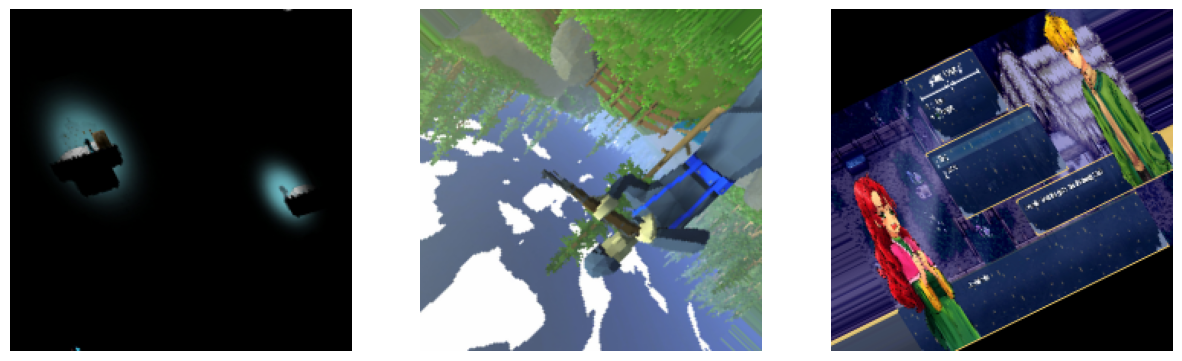

In [17]:
# Retrieve a batch of images from the train_generator
batch = train_generator.next()

# Get the images and labels from the batch
images = batch[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 
for i in range(3):
    axes[i].imshow(images[i]) 
    axes[i].axis('off')

plt.show()

### 2.2 Model Architecture
In this section the architecture of developed CNN is explained. For this assignment, we decided to use the principle of transfer learning by using pre-trained and fine-tuned models on the video games images. To generate the architecture, some steps that we followed in the process are:

1. Selection of the base model for transfer learning. When doing research, we noticed that there were many transfer learning models available. Several models that we tried for this assignment are: EfficientNetB0, EfficientNetV2S, VGG16, ResNet50, InceptionV3 and Xception. In the end, ResNet50 with pre-trained weights from the "imagenet" dataset generated the best fit. This was also the model that was used in a paper on video game classification (https://digitalcommons.wku.edu/cgi/viewcontent.cgi?article=4467&context=theses).

1. After the selection of the deep learning model, we needed to adapt the architecture to our dataset. Firstly, we removed the last layer from the pre-trained model. All other layers from the pre-trained model are kept frozen. Then, we added some additional layers on top of the frozen model (https://keras.io/guides/transfer_learning/). Also here, online research showed that there was a wide variety of layers and combinations of layers that could be placed on top of a pre-trained model. When developing the last layers of the CNN, we needed to be mindful of potential overfitting (https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/). Regarding the dropout, we tried a range of dropout values from 0.1 to 0.3. In the end we decided to use 0.3 to prevent overfitting. We also added Batch Normalization layers to prevent overfitting, improve the accuracy and make the model more stable (according to this paper https://arxiv.org/abs/1502.03167). Further, we tried some different combinations of architecture layers. This did not drastically improve our results. 

1. Finally, we had to choose the activation function of our last layer. Since we are building a regression CNN, we initially selected a linear activation function. When we further analyzed the predicted game prices, we noticed that the model was predicting negative game prices. To rectify this issue, we switched to a ReLu activation function for the last layer. This activation function prevents the prediction of negative prices. 

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential


inputs= layers.Input(shape=(height, width, 3))


base_model = ResNet50(
    include_top=False, #Drop the last layer
    weights="imagenet",
    input_tensor = inputs,
    pooling=None
)

# Freeze the base model
base_model.trainable = False

x = base_model(inputs, training=False)

# Add a few layers on top
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3, name="top_dropout")(x)
x = layers.BatchNormalization()(x) # inspired by 
outputs = layers.Dense(1, activation = 'relu', name="prediction")(x) # Used ReLu activation function because prices are always positive

model = keras.Model(inputs, outputs)

The following image visualizes the architecture of the CNN we trained. This model shows that the input has a shape of (224, 224, 3), uses the pre-trained ResNet50 model and includes all the additional layers we added on top of ResNet50 to adapt it to our dataset.

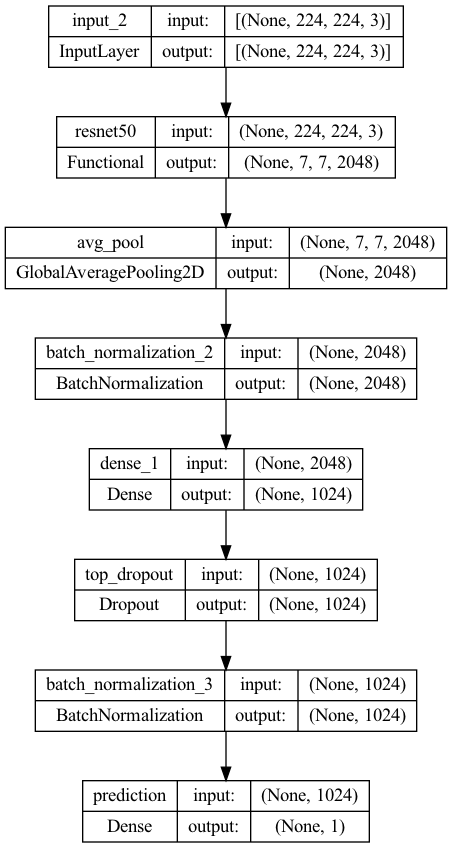

In [14]:
from keras.utils import plot_model
import pydot
from IPython.display import Image

# Display the image
Image(filename='Method1.png')

### 2.3 Model Fitting
After defining the architecture of the model, the model needs to be compiled and fitted. In this step some additional key decisions are made that influence how well the model fits to the data.

1. The learning rate. This is a key parameter that determines the speed of learning. This hyperparameter needs to be set in accordance with other parameters, such as the batch size. We chose the Adam optimizer due to it still being one of the best performing learning rate optimizers. The main drawbacks of Adam is that it can get stuck in saddle points or local minima and that the model is very sensitive to the initial learning rate. To address this, we added a learning rate scheduler using the Cyclical Learning Rate (paper: https://arxiv.org/pdf/1506.01186). During the training, the learning rate oscillates between a predetermined maximum (0.01) and minimum (0.0000001) learning rate. Additionally, the paper specifies that the CLR step size needs to be set equal to "2-10 times the number of iterations in an epoch". We decided to use 4 times the number of iterations in an epoch. By using the CLR, we have more freedom in setting the initial learning rate and we have reduced the risk of getting stuck in a saddle point or local minima. After fitting the model, a graph will illustrate how the learning rate oscillated. 

1. Early stopping mechanism. This is another methodology that we applied to prevent overfitting. This method stops the training of the model when the validation loss starts to increase too much (i.e., the model is overfitting). As input parameters, we set that the early stopping mechanism can only be activated after epoch 3. Then, for the consecutive epochs, an evaluation is made on whether the validation loss increased or not. If the validation loss increases for two consecutive epochs (patience=1), training is stopped.

1. The loss function. When compiling the model, it is important to distinguish between "loss" and "metric." The loss function is minimized during training, while the metric evaluates model performance. We used the Mean Absolute Error as the metric to compare different models that we fitted. Regarding the loss functions, several loss functions were tested: the Mean Absolute Error, the Root Mean Squared Error, the Mean Average Percentage Error and the Huber loss. For method 1, we decided to use the Huber loss due to its robustness to outliers (as mentioned before we still have some games above 2000¢) and its combination of squared error and absolute error. Additionally, we performed some other small experiments and found that the Mean Absolute Error performed better than the Root Mean Squared Error. 

In [15]:
# Adding cyclical learning rate
from keras.callbacks import *
from clr_callback import CyclicLR
from keras.optimizers import Adam
from keras.losses import Huber

#set the CLR options
clr_step_size = int(4 * (len(train_generator)/batch_size)) 
base_lr = 1e-7
max_lr = 1e-2
mode='triangular'


# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
clr_triangular = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=clr_step_size, mode=mode)
opt = Adam(0.0008)

# Adding an early stopping mechanism
EarlyStoppinng = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=1,
    verbose=1,
    start_from_epoch=3,
)

model.compile(optimizer=opt, loss=Huber(delta=1.0), metrics=[keras.metrics.MeanAbsoluteError()])
print("Model is compiled")


Model is compiled


Next, all elements explained above are combined to fit the model. We needed to specify the steps_per_epoch and validation_steps to avoid warning messages about insufficient input data during the epochs. These values were explicitly defined to ensure smooth training.

We decided to limit the training to 6 epochs. However, the early stopping mechanism halted the training after epoch 5 due to the increase in validation loss. For each epoch, the training loss (Huber) and Mean Absolute Error (MAE) are printed, along with the validation loss. This allows us to track the evolution of the model's performance throughout the training process.

In [16]:
history = model.fit(
    train_data= train_generator,
    callbacks=[EarlyStoppinng, clr_triangular],
    steps_per_epoch=train_generator.n//batch_size,
    epochs=6,
    validation_data=val_generator,
    validation_steps = val_generator.n//batch_size
)

Epoch 1/6


2024-05-22 23:29:03.571771: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2394/2394 [==============================] - 4839s 2s/step - loss: 651.4397 - mean_absolute_error: 651.9377 - val_loss: 662.4385 - val_mean_absolute_error: 662.9377
Epoch 2/6
2394/2394 [==============================] - 4869s 2s/step - loss: 636.2138 - mean_absolute_error: 636.7136 - val_loss: 661.6533 - val_mean_absolute_error: 662.1522
Epoch 3/6
2394/2394 [==============================] - 4852s 2s/step - loss: 635.4386 - mean_absolute_error: 635.9385 - val_loss: 663.2850 - val_mean_absolute_error: 663.7844
Epoch 4/6
2394/2394 [==============================] - 4840s 2s/step - loss: 635.0746 - mean_absolute_error: 635.5743 - val_loss: 662.2110 - val_mean_absolute_error: 662.7097
Epoch 5/6
2394/2394 [==============================] - 4843s 2s/step - loss: 635.4959 - mean_absolute_error: 635.9957 - val_loss: 664.1028 - val_mean_absolute_error: 664.6022
Epoch 5: early stopping


The figure below illustrates the evolution of the training and validation MAE across the epochs. It illustrates that the training loss experienced a rapid decrease in the first epoch before stabilizing. Meanwhile, the validation loss remained relatively stable throughout the epochs. From this visualization, one might get the impression that our learning rate is set too high. However, the accompanying graph on the right shows the evolution of the Cyclical Learning Rate, indicating that the learning rate oscillated between a "higher" and a "lower" value. Therefore, the argument of a too high learning rate may not be entirely valid.

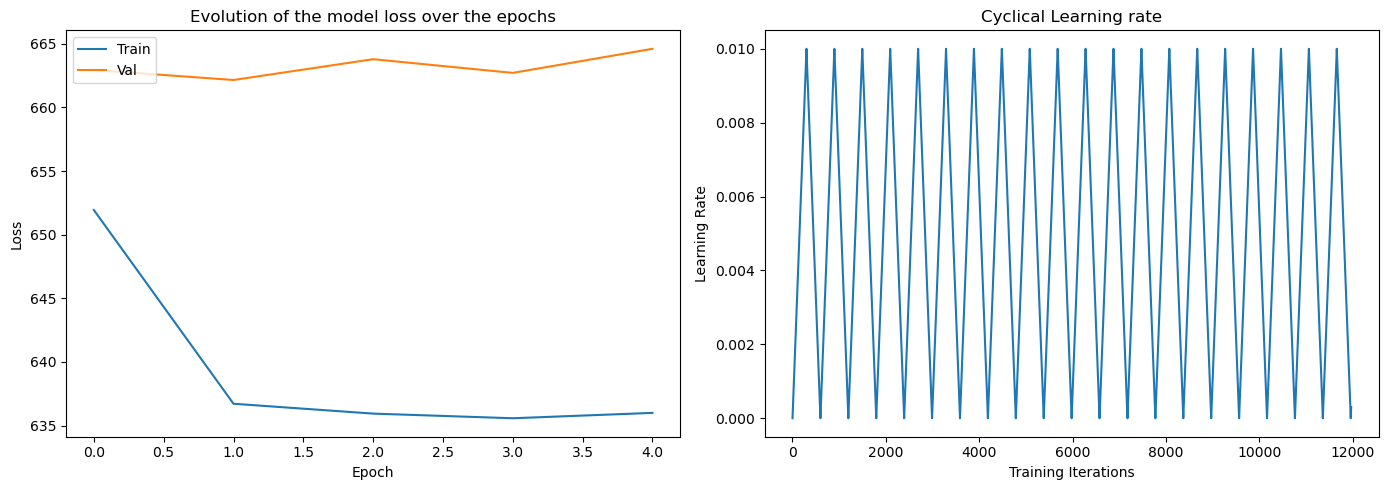

In [17]:
# Create a figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plotting the error
ax1.plot(history.history['mean_absolute_error'])
ax1.plot(history.history['val_mean_absolute_error'])
ax1.set_title('Evolution of the model loss over the epochs')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Val'], loc='upper left')

# Plot how the cyclical learning rate moves
ax2.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])
ax2.set_xlabel('Training Iterations')
ax2.set_ylabel('Learning Rate')
ax2.set_title("Cyclical Learning rate")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### 2.4 Model Evaluation
In this section, the developed model is evaluated using the test set. The normalized images serve as inputs of the model.evaluate function. The test set yielded a MAE of 651.98. This implies that, on average, the predicted price differs from the actual price by 6.52 USD. While this error remains significant, it is worth noting that alternative architectures and learning rates that we experimented with did not lead to an improvement in this score.

In [18]:
loss, mean_absolute_error = model.evaluate(test_generator, steps = test_generator.n//batch_size)
print("Test MAE:", mean_absolute_error)

799/799 [==============================] - 1178s 1s/step - loss: 651.4871 - mean_absolute_error: 651.9863
Test MAE: 651.986328125


We additionally made an analysis on how well our model predicts the images in the test set. For each image in the test set, the CNN is utilized to predict the game price. It is important to note that we did not account for the possibility that multiple screenshots may belong to the same game. Consequently, the model might predict different prices for screenshots belonging to the same game. Following this analysis, a short discussion is provided in Section 2.7 regarding the feasibility of this methodology.

The code below generates a dataframe containing the predicted price for each screenshot according to the model. It's crucial to remember that the input images must also be normalized before making predictions.

In [19]:
pred = []

for i in range(len(test_label_df)):
    filename = test_label_df.iloc[i]["screenshot"]
    image_path = os.path.join(image_location, filename)
    img = keras.utils.load_img(image_path, target_size=(224, 224))


    img_array = keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image data
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array, verbose=0)
    price_difference = predictions[0][0] - test_label_df.iloc[i]["price"]
    pred.append({'price': predictions[0][0], 'difference': price_difference})

    #print('prediction ', i , predictions[0][0] , 'Difference:', price_difference)

predictions_test = pd.DataFrame(pred)
predictions_test.head()

price  difference
0  547.712830 -427.287170
1  607.041992 -367.958008
2  528.308960 -446.691040
3  595.916992 -379.083008
4  514.410889 -460.589111

Next, we plotted the actual prices of the screenshots against the predicted prices. This graph indicates that our model does not make any predictions above 2100¢. This limitation could be attributed to the fact that, as mentioned in the EDA, the majority of the games have prices below 2000¢. Consequently, the model may have focused on these lower-priced games during training, resulting in difficulty predicting higher-priced games. For games priced below 1500¢, the model appears to perform relatively well.

Text(0.5, 0, 'Actual price')

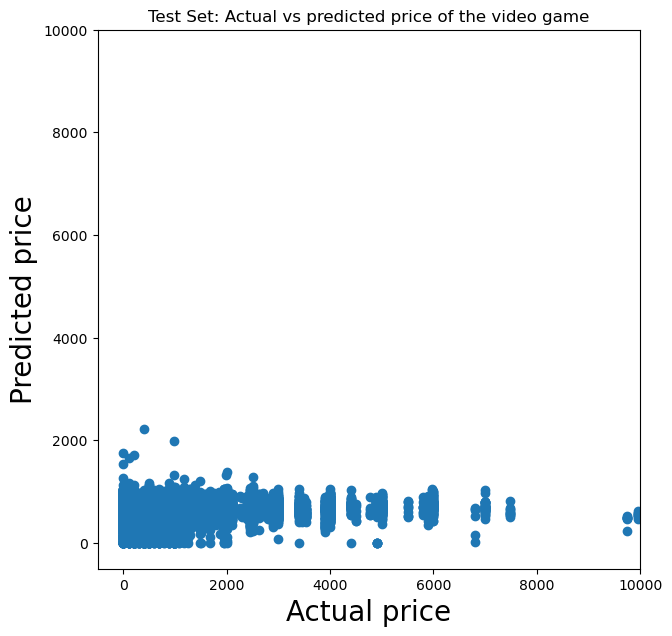

In [20]:
plt.figure(figsize = (7,7))
plt.axis([-500, 10000, -500, 10000])
plt.scatter(test_label_df['price'], predictions_test['price'])
plt.title("Test Set: Actual vs predicted price of the video game")
plt.ylabel("Predicted price", size=20)
plt.xlabel("Actual price", size=20)

Below, some additional evaluation metrics are given. These also illustrate that the model is not performing very well.

In [21]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_label_df['price'], predictions_test['price']))
print('Mean Squared Error:', metrics.mean_squared_error(test_label_df['price'], predictions_test['price']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_label_df['price'], predictions_test['price'])))
print('R2 score:', metrics.r2_score(test_label_df['price'], predictions_test['price']))

Mean Absolute Error: 651.8617731839707
Mean Squared Error: 1114464.4934305425
Root Mean Squared Error: 1055.6820039342067
R2 score: -0.07010361075037408


The histogram below illustrates the distribution of differences between the predicted and actual prices of the screenshots. This visualization allows us to assess the distribution of errors and gain further insights into where the model may be struggling. The majority of differences are centered around 0, indicating that the model tends to predict prices close to the actual values. However, the histogram exhibits a negative skew, suggesting that the model tends to underestimate game prices. This observation aligns with the chart above, which indicated that the model does not make predictions above 2100¢.

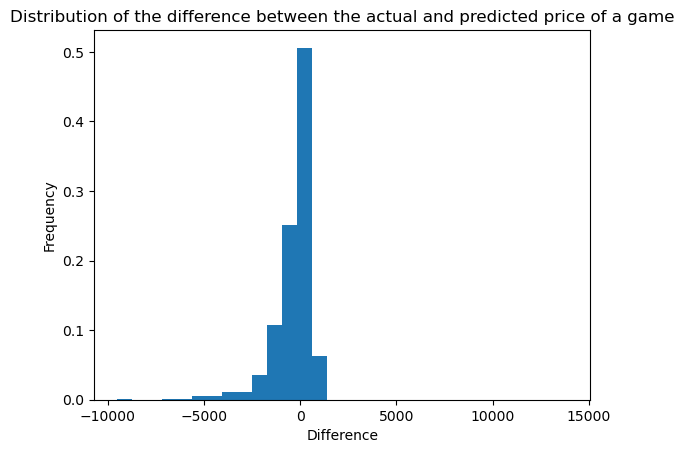

In [22]:
# Plot histogram of the differences in price
# Multiply y-axis values by 100 to represent percentages
plt.hist(predictions_test['difference'], weights=np.zeros_like(predictions_test['difference']) + 1. / predictions_test['difference'].size, bins=30)

# Add labels and title
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Distribution of the difference between the actual and predicted price of a game')

# Show plot
plt.show()

### 2.5 Image Predictions
Below, the fitted CNN is utilized to predict the video game price based on one screenshot. For each image, both the actual price and the predicted price are provided. As expected, the model is not accurately predicting the price of the video games.

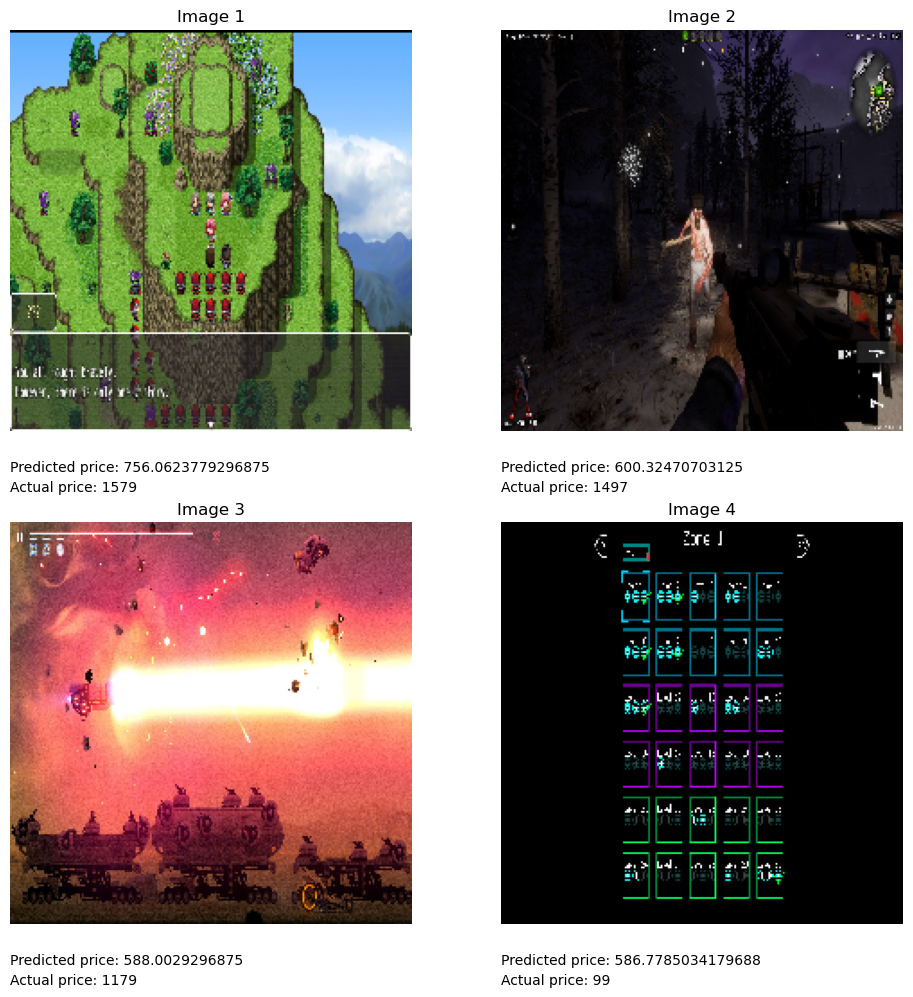

In [23]:
def display_images_with_predictions(image_numbers, test_label_df, image_location, model, height, width):
    num_images = len(image_numbers)
    num_rows = (num_images + 1) // 2 
    
    plt.figure(figsize=(10, 10))  # Set figure size
    
    for i, number in enumerate(image_numbers, start=1):
        filename = test_label_df.loc[number, "screenshot"]
        image_path = os.path.join(image_location, filename)
        
        # Load and display the image
        img = keras.utils.load_img(image_path, target_size=(height, width))
        plt.subplot(num_rows, 2, i)
        plt.imshow(img)
        plt.title(f"Image {i}")
        plt.axis('off')

        img_array = keras.utils.img_to_array(img)
        img_array = img_array / 255.0
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis

        predictions_example = model.predict(img_array, verbose=0)[0][0]
        actual_price = test_label_df.loc[number, 'price']

        # Display predicted and actual price underneath the image
        plt.text(0, -0.1, f'Predicted price: {predictions_example}', transform=plt.gca().transAxes)
        plt.text(0, -0.15, f'Actual price: {actual_price}', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()


image_numbers = [450, 500, 600, 700]  # Example list of image numbers
display_images_with_predictions(image_numbers, test_label_df, image_location, model, height, width)

### 2.6 Interpretability Using Saliency Plots
Lastly, saliency maps were used to assess which regions of the image are most influential when the model is determining the price of the video game. To construct the saliency maps, we utilized the tf-keras-vis package from GitHub (https://github.com/keisen/tf-keras-vis/tree/master). To generate the saliency map using this package, we utilized SmoothGrad and adapted the code provided in the repository to a regression problem. The original picture and its corresponding saliency map are illustrated below. Based on these saliency maps, it appears that the model is focusing on certain edges or characters in the frame.
While we attempted to implement other interpretability techniques, the use of a pre-trained model limited us in the functions from the package that we could apply.

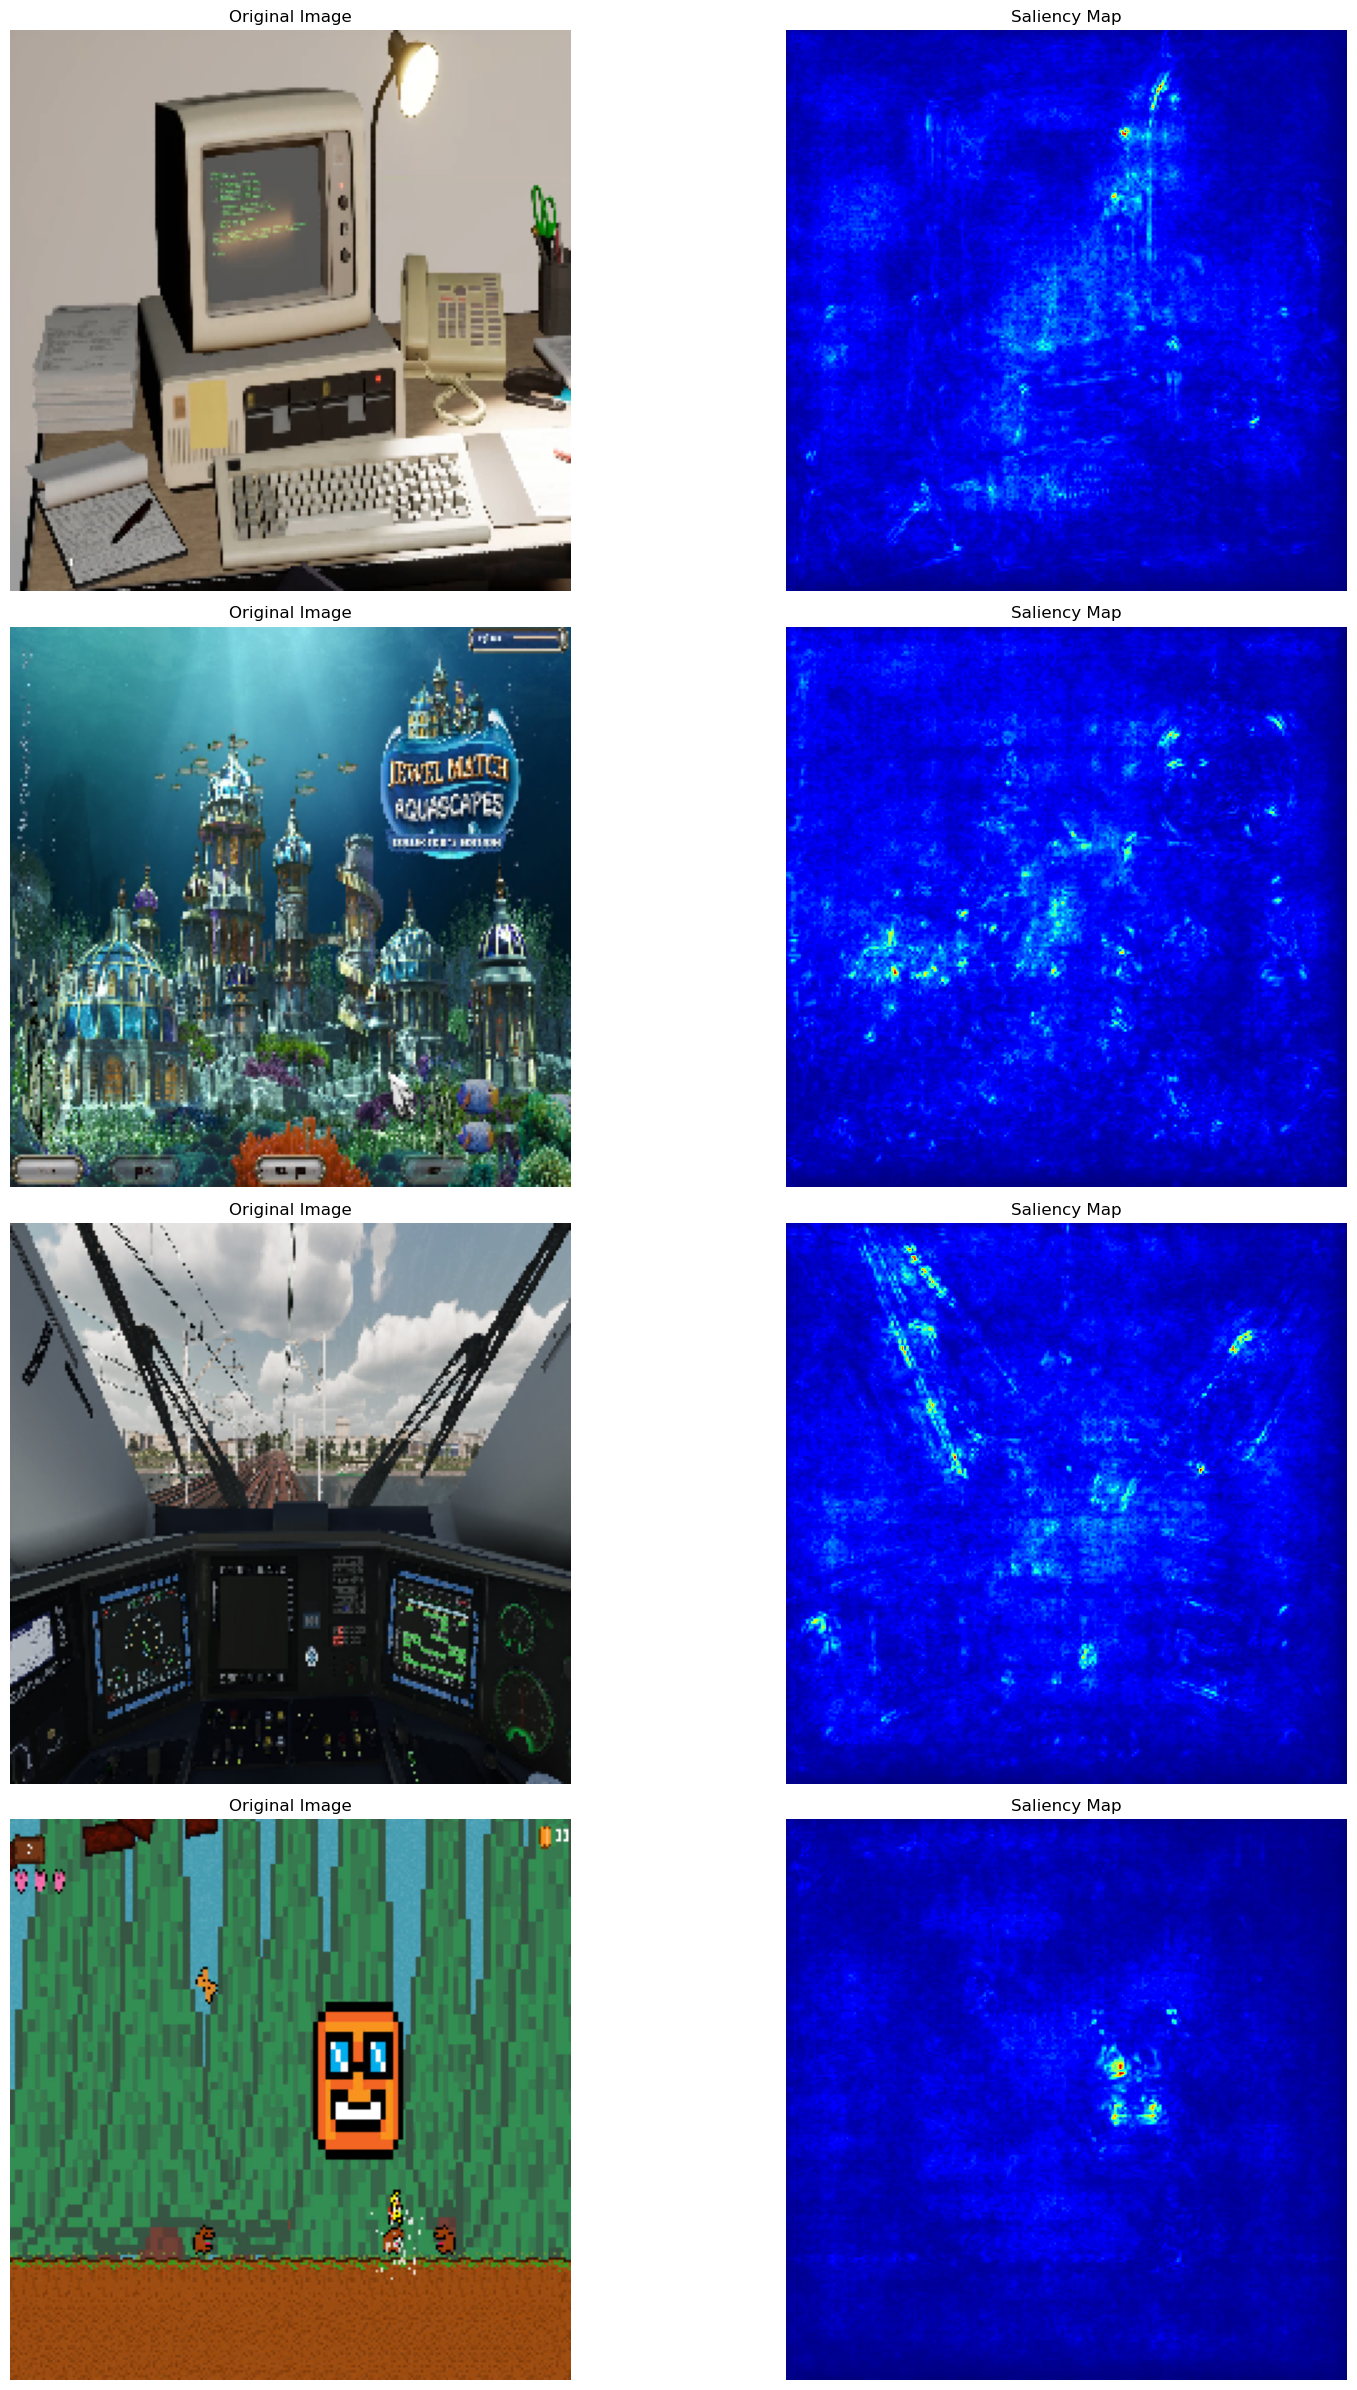

In [25]:
from matplotlib import pyplot as plt
import os
from tensorflow import keras

# Define the image location
numbers = [111, 567, 123, 999]  # Specify the numbers of the images to select
filenames = [test_label_df.loc[number, "screenshot"] for number in numbers]
prices = [test_label_df.loc[number, "price"] for number in numbers]

# Construct the full paths to the images
image_paths = [os.path.join(image_location, filename) for filename in filenames]

# Load the images
plt.rcParams['figure.figsize'] = (18, 24)

# Preprocess images, so that they are normalized
imgs = [keras.utils.load_img(image_path, target_size=(height, width)) for image_path in image_paths]
img_arrays = [keras.utils.img_to_array(img) / 255.0 for img in imgs]

# Model modifier: Such that the last layer has a linear activation function.
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
replace2linear = ReplaceToLinear()

# Score function: should return the target score
def score(output):
    return output[0][0]

from tf_keras_vis.saliency import Saliency

# Create Gradcam object
saliency = Saliency(model, model_modifier=replace2linear, clone=True)

# Generate heatmap with GradCAM for each image
saliency_maps = []
for img_array in img_arrays:
    saliency_map = saliency(score, img_array, smooth_samples=20, smooth_noise=0.20)
    saliency_maps.append(saliency_map[0])

# Plot the original images above their saliency maps in a 4x2 grid
f, ax = plt.subplots(4, 2)

for i in range(4):
    # Plot original image
    ax[i, 0].imshow(imgs[i])
    ax[i, 0].set_title(f"Original Image")
    ax[i, 0].axis('off')

    # Plot saliency map
    ax[i, 1].imshow(saliency_maps[i], cmap='jet')
    ax[i, 1].set_title(f"Saliency Map")
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

### 2.7 Discussion Method 1
The first method we developed analyzed each screenshot independently, disregarding the fact that games can have multiple images. Consequently, during the evaluation of method 1, individual screenshots were considered, potentially resulting in different predicted prices for each screenshot of the same game. To predict the price of a single game with multiple screenshots using method 1, one workaround would be to calculate the average price of all screenshots belonging to that game. However, it is crucial to note that the CNN was not trained using this approach. Therefore, comparing the performance of method 1, which evaluates individual screenshots, with this average-based evaluation metric would essentially compare two different evaluation methods.

By not considering the relationship between different screenshots of the same game, we overlook important data. This realization led us to develop method 2 and method 3, where we analyze multiple images of a game to account for this aspect.

## 3. Method 2: Multi-Input CNN
In this second methodology, a multi-input CNN is developed. This concept was inspired by the paper titled "Multi-Input Convolutional Neural Network for Flower Classification" (https://www.hindawi.com/journals/jece/2017/9240407/), where different pictures of the same flower are utilized as inputs to a deep learning model for flower classification. Implementing this methodology required additional preprocessing steps and a different architecture for the CNN. Changes and adaptations compared to method 1 will be discussed in detail in this section. Any aspects that remain the same as in method 1 will be briefly mentioned but not explained further.

### 3.1 Preprocessing
Starting from the general dataset, where outliers above 10,000¢ are already removed, additional methodology-specific preprocessing is performed in this section.
#### 3.1.1 Developing the Dataframe
In this preprocessing step, a different dataframe is generated compared to the dataframe from method 1. Instead of having one column with the screenshot name (x_col), we now require multiple columns with the screenshots of a video game. Therefore, as a first step, we selected each screenshot of a game and placed it in a separate column. Below are the first 5 rows of the new dataframe:

In [9]:
screenshots_new = selected_games_no_outliers['screenshots'].apply(pd.Series)
screenshots_new.head() #Print the new dataframe

0   \
14542  2203540_ss_00e237a17c29f0b3f535be5bbaf1aca1291...   
2007   2747740_ss_2680d60077208ff4397d1d6109eee41e4f7...   
14202  2263550_ss_003ae84254705fc2976b3302a9a7cad59d3...   
6681   2562290_ss_1279e5037cd663de37348356a3e0f49b230...   
12942  2299920_ss_068a09669ef97ddb9c79c2ca29ef7945dcc...   

                                                      1   \
14542  2203540_ss_1a1c09618fa769453a86ec361523bb56c87...   
2007   2747740_ss_391fdbf16da101beb045a88c28e038e0dc3...   
14202  2263550_ss_4ba42c4d41d345ce4ad54cdbaac74da3487...   
6681   2562290_ss_192326a1b1396941cef092ecdf82103a1ba...   
12942  2299920_ss_0a3f51dc8d1387c051bb0b6239ec3ee2ac2...   

                                                      2   \
14542  2203540_ss_2a7f60e28946eeba3f693cfbbcd911ce86f...   
2007   2747740_ss_3e21413e0407fc7a35f74faa17273690b10...   
14202  2263550_ss_55e8ffdfcac29d51e3477f128d04d5023e4...   
6681   2562290_ss_432ad434f4bf03ffb95d05e0affec1fc5d2...   
12942  2299920_ss_0ac1e97493ca3283d73e36bb9f00115c6d9...   

                                                      3   \
14542  2203540_ss_4bfd302dbed6cf7ea5918f0fc9889a4dfce...   
2007   2747740_ss_745066e53a1d198e533cde89f6a88de086c...   
14202  2263550_ss_9e6120400646fc8c47512afd49979b3a92e...   
6681   2562290_ss_73fefb1fa059409880d1f416508a224dced...   
12942  2299920_ss_23e3a1de35a8378e3e2cbddb8cf74b137e1...   

                                                      4   \
14542  2203540_ss_57481680e8c02e3dc6bc269e5543c36f407...   
2007   2747740_ss_8b4f0e299eeb011616fcac9fb3ef58761b8...   
14202  2263550_ss_f62c53d9cd31ca9c6599b9e50a37b86160b...   
6681   2562290_ss_d8c9e249d251b5fb93f13f818b212074731...   
12942  2299920_ss_33d9b7158ba8ae1019de2bd2277f147ab00...   

                                                      5   \
14542  2203540_ss_612dab69a97e6bc5e9e4e7a53b970248dbb...   
2007                                                 NaN   
14202  2263550_ss_fdd57a121c4bbd350261606d180f1a88221...   
6681                                                 NaN   
12942  2299920_ss_3740347ab51dbaf23e954b25bc860566d8e...   

                                                      6   \
14542  2203540_ss_668b84bb5c268642426a986130de57492e6...   
2007                                                 NaN   
14202  2263550_ss_fdda3138cd0172a67bd0533652384f4a16b...   
6681                                                 NaN   
12942  2299920_ss_645d176075ee0ffc545f23adc5e31ca4948...   

                                                      7   \
14542  2203540_ss_773a259226938c797b7e2702c20a528844b...   
2007                                                 NaN   
14202                                                NaN   
6681                                                 NaN   
12942                                                NaN   

                                                      8   \
14542  2203540_ss_80e1925f5f07f07a88346d7b2bc898da97b...   
2007                                                 NaN   
14202                                                NaN   
6681                                                 NaN   
12942                                                NaN   

                                                      9   ...   75   76   77  \
14542  2203540_ss_bd0722a3320e860f06ee6b275693fc0044a...  ...  NaN  NaN  NaN   
2007                                                 NaN  ...  NaN  NaN  NaN   
14202                                                NaN  ...  NaN  NaN  NaN   
6681                                                 NaN  ...  NaN  NaN  NaN   
12942                                                NaN  ...  NaN  NaN  NaN   

        78   79   80   81   82   83   84  
14542  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2007   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
14202  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6681   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
12942  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 85 columns]

Notice that the games have an unequal number of screenshots. Some games have only 4 screenshots, while other games have up to 84 screenshots. As a result, for games with fewer screenshots, there are empty columns containing NaNs. Since the multi-input CNN cannot handle empty inputs, we decided to address this issue by filling the empty columns with randomly selected screenshots from the same game. After this adaptation, our dataset consists of 84 columns containing screenshots of the video game (the input) and a column containing the price of a game (the output). Below is the code and an illustration of the newly generated dataframe.

In [10]:
# Function to replace NaN values with a random non-NaN value from previous columns
def replace_nan_with_random(df):
    for index, row in df.iterrows():
        for col_index, value in row.items():
            if pd.isnull(value):
                # Get previous non-NaN values in the row
                previous_values = row[:col_index][::-1]
                previous_values = previous_values.dropna()
                
                if not previous_values.empty:
                    # Select a random non-NaN value from previous columns
                    random_value = previous_values.sample().iloc[0]
                    # Replace NaN with the randomly selected value
                    df.at[index, col_index] = random_value

# Call the function to replace NaN values with random non-NaN values
replace_nan_with_random(screenshots_new)

# Add the price
result_df = pd.concat([selected_games_no_outliers['price'], screenshots_new], axis=1)
result_df.head()

price                                                  0  \
14542    399  2203540_ss_00e237a17c29f0b3f535be5bbaf1aca1291...   
2007       0  2747740_ss_2680d60077208ff4397d1d6109eee41e4f7...   
14202      0  2263550_ss_003ae84254705fc2976b3302a9a7cad59d3...   
6681     499  2562290_ss_1279e5037cd663de37348356a3e0f49b230...   
12942    499  2299920_ss_068a09669ef97ddb9c79c2ca29ef7945dcc...   

                                                       1  \
14542  2203540_ss_1a1c09618fa769453a86ec361523bb56c87...   
2007   2747740_ss_391fdbf16da101beb045a88c28e038e0dc3...   
14202  2263550_ss_4ba42c4d41d345ce4ad54cdbaac74da3487...   
6681   2562290_ss_192326a1b1396941cef092ecdf82103a1ba...   
12942  2299920_ss_0a3f51dc8d1387c051bb0b6239ec3ee2ac2...   

                                                       2  \
14542  2203540_ss_2a7f60e28946eeba3f693cfbbcd911ce86f...   
2007   2747740_ss_3e21413e0407fc7a35f74faa17273690b10...   
14202  2263550_ss_55e8ffdfcac29d51e3477f128d04d5023e4...   
6681   2562290_ss_432ad434f4bf03ffb95d05e0affec1fc5d2...   
12942  2299920_ss_0ac1e97493ca3283d73e36bb9f00115c6d9...   

                                                       3  \
14542  2203540_ss_4bfd302dbed6cf7ea5918f0fc9889a4dfce...   
2007   2747740_ss_745066e53a1d198e533cde89f6a88de086c...   
14202  2263550_ss_9e6120400646fc8c47512afd49979b3a92e...   
6681   2562290_ss_73fefb1fa059409880d1f416508a224dced...   
12942  2299920_ss_23e3a1de35a8378e3e2cbddb8cf74b137e1...   

                                                       4  \
14542  2203540_ss_57481680e8c02e3dc6bc269e5543c36f407...   
2007   2747740_ss_8b4f0e299eeb011616fcac9fb3ef58761b8...   
14202  2263550_ss_f62c53d9cd31ca9c6599b9e50a37b86160b...   
6681   2562290_ss_d8c9e249d251b5fb93f13f818b212074731...   
12942  2299920_ss_33d9b7158ba8ae1019de2bd2277f147ab00...   

                                                       5  \
14542  2203540_ss_612dab69a97e6bc5e9e4e7a53b970248dbb...   
2007   2747740_ss_2680d60077208ff4397d1d6109eee41e4f7...   
14202  2263550_ss_fdd57a121c4bbd350261606d180f1a88221...   
6681   2562290_ss_73fefb1fa059409880d1f416508a224dced...   
12942  2299920_ss_3740347ab51dbaf23e954b25bc860566d8e...   

                                                       6  \
14542  2203540_ss_668b84bb5c268642426a986130de57492e6...   
2007   2747740_ss_8b4f0e299eeb011616fcac9fb3ef58761b8...   
14202  2263550_ss_fdda3138cd0172a67bd0533652384f4a16b...   
6681   2562290_ss_432ad434f4bf03ffb95d05e0affec1fc5d2...   
12942  2299920_ss_645d176075ee0ffc545f23adc5e31ca4948...   

                                                       7  \
14542  2203540_ss_773a259226938c797b7e2702c20a528844b...   
2007   2747740_ss_8b4f0e299eeb011616fcac9fb3ef58761b8...   
14202  2263550_ss_fdda3138cd0172a67bd0533652384f4a16b...   
6681   2562290_ss_432ad434f4bf03ffb95d05e0affec1fc5d2...   
12942  2299920_ss_3740347ab51dbaf23e954b25bc860566d8e...   

                                                       8  ...  \
14542  2203540_ss_80e1925f5f07f07a88346d7b2bc898da97b...  ...   
2007   2747740_ss_8b4f0e299eeb011616fcac9fb3ef58761b8...  ...   
14202  2263550_ss_fdda3138cd0172a67bd0533652384f4a16b...  ...   
6681   2562290_ss_432ad434f4bf03ffb95d05e0affec1fc5d2...  ...   
12942  2299920_ss_23e3a1de35a8378e3e2cbddb8cf74b137e1...  ...   

                                                      75  \
14542  2203540_ss_612dab69a97e6bc5e9e4e7a53b970248dbb...   
2007   2747740_ss_2680d60077208ff4397d1d6109eee41e4f7...   
14202  2263550_ss_fdda3138cd0172a67bd0533652384f4a16b...   
6681   2562290_ss_432ad434f4bf03ffb95d05e0affec1fc5d2...   
12942  2299920_ss_3740347ab51dbaf23e954b25bc860566d8e...   

                                                      76  \
14542  2203540_ss_00e237a17c29f0b3f535be5bbaf1aca1291...   
2007   2747740_ss_8b4f0e299eeb011616fcac9fb3ef58761b8...   
14202  2263550_ss_fdd57a121c4bbd350261606d180f1a88221...   
6681   2562290_ss_d8c9e249d251b5fb93f13f818b212074731...   
12942  2299920_ss_068a096

#### 3.1.2 Train Test Split
Given the utilization of a different dataframe, the train test split must be redone accordingly. Once more, we performed a 60/20/20 split with the same random_state as in method 1. This ensures that the models are trained, validated, and tested on the same images. However, in this case, the images belonging to the same game are kept together in the input.

In [11]:
from sklearn.model_selection import train_test_split
# Split data into training and validation sets based on games
train1_games, test_games = train_test_split(result_df, test_size=0.2, random_state=42)
train_games, val_games = train_test_split(train1_games, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

#### 3.1.3 Normalization and Image Augmentation
To normalize and augment the images using the ImageDataGenerators from Section 1.2, we need to modify the approach used in method 1. Instead of running the function '.flow_from_dataframe' once (as is done in method 1), it must now be done several times depending on the number of images used as input of the model. Since we want to try different numbers of inputs (e.g., 5-input, 7-input, 10-input) in our CNN, we need to define a flexible function capable of applying this. After a lot of research on discussion boards on Stack Overflow and GitHub, we found the following discussion thread https://github.com/keras-team/keras/issues/8130. By adapting the code from this thread, we managed to create a function where you can specify how many inputs your CNN has. This function then also takes the ImageDataGenerator and the dataset as input parameters on which it performs normalization and data augmentation.

In [12]:
def generate_generator_multiple(generator, dataframe, batch_size, img_height, img_width, num_columns=7):
    generators = []
    
    for i in range(num_columns): # Run over all columns
        genX = generator.flow_from_dataframe(dataframe=dataframe, directory=image_location, color_mode="rgb",
                                             target_size=(img_height, img_width),
                                             x_col=i, y_col="price", has_ext=True, #specify the which column needs to be loaded
                                             class_mode="other",
                                             batch_size=batch_size,
                                             shuffle=False,
                                             seed=7)
        generators.append(genX)
       

    while True:
        batch_X = []
        batch_Y = None
        
        for genX in generators: #Create one large generator
            X, Y = genX.next()
            batch_X.append(X)
            if batch_Y is None:
                batch_Y = Y
        
        yield batch_X, batch_Y

Below, the 'generate_generator_multiple' function is applied to the training, validation, and test set respectively.

In [13]:
inputgenerator=generate_generator_multiple(generator=train_datagen, dataframe=train_games,
                                           batch_size=batch_size,
                                           img_height=height,
                                           img_width=width)       

valgenerator=generate_generator_multiple(val_datagen, dataframe=val_games,
                                          batch_size=batch_size,
                                          img_height=height,
                                          img_width=width)   
     
testgenerator=generate_generator_multiple(test_datagen, dataframe=test_games,
                                          batch_size=batch_size,
                                          img_height=height,
                                          img_width=width)

### 3.2 Model Architecture

In contrast to method 1, where only one input is defined, method 2 requires defining multiple inputs. During our experimentation with different models, we varied the number of inputs from 5 to 10. However, we found that using more than 10 inputs significantly increased computation time without improving performance. Ultimately, a 7-input model showed better performance compared to models with more inputs, possibly due to the risk of overfitting when including more inputs.

To utilize these 7 images as inputs, we employed the Functional API provided by Keras (https://keras.io/guides/functional_api/). First, each input was identified and given a unique name. Then, we ran each image through the pre-trained model. The same pre-trained model(ResNet50) was used as in method 1. Then, the outputs of each image from the ResNet50 were concatenated (as explained on this website https://wavicledata.com/blog/deep-multi-input-models-transfer-learning-for-image-and-word-tag-recognition/). Then, on top of the concatenated layer, we constructed the same architecture layers as in method 1. Once again, Dropout and Batch Normalization were used to prevent overfitting, and a ReLU activation function was applied in the final layer.

In [14]:
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model


input_x_1 = Input(shape=(224, 224, 3), name='input_1')
input_x_2 = Input(shape=(224, 224, 3), name='input_2')
input_x_3 = Input(shape=(224, 224, 3), name='input_3')
input_x_4 = Input(shape=(224, 224, 3), name='input_4')
input_x_5 = Input(shape=(224, 224, 3), name='input_5')
input_x_6 = Input(shape=(224, 224, 3), name='input_6')
input_x_7 = Input(shape=(224, 224, 3), name='input_7')


#Shared layer
base_model = ResNet50(
    include_top=False, #Drop the last layer
    weights="imagenet",
    input_shape= (224, 224, 3),
    pooling=None
)
base_model.trainable = False


x1 = base_model(input_x_1, training=False)
x2 = base_model(input_x_2, training=False)
x3 = base_model(input_x_3, training=False)
x4 = base_model(input_x_4, training=False)
x5 = base_model(input_x_5, training=False)
x6 = base_model(input_x_6, training=False)
x7 = base_model(input_x_7, training=False)

# Concatenate the multiple inputs
x = Concatenate()([x1, x2, x3, x4, x5, x6, x7])

# Add a layer on top
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3, name="top_dropout")(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation = 'relu', name="prediction")(x)

model = Model(inputs= [input_x_1, input_x_2, input_x_3, input_x_4, input_x_5, input_x_6, input_x_7], outputs= outputs)


Below is a visualization of the architecture of the generated model. Each individual image is used as input in the ResNet50 model, after which concatenation is performed. All subsequent layers after the concatenation are the same as in method 1.

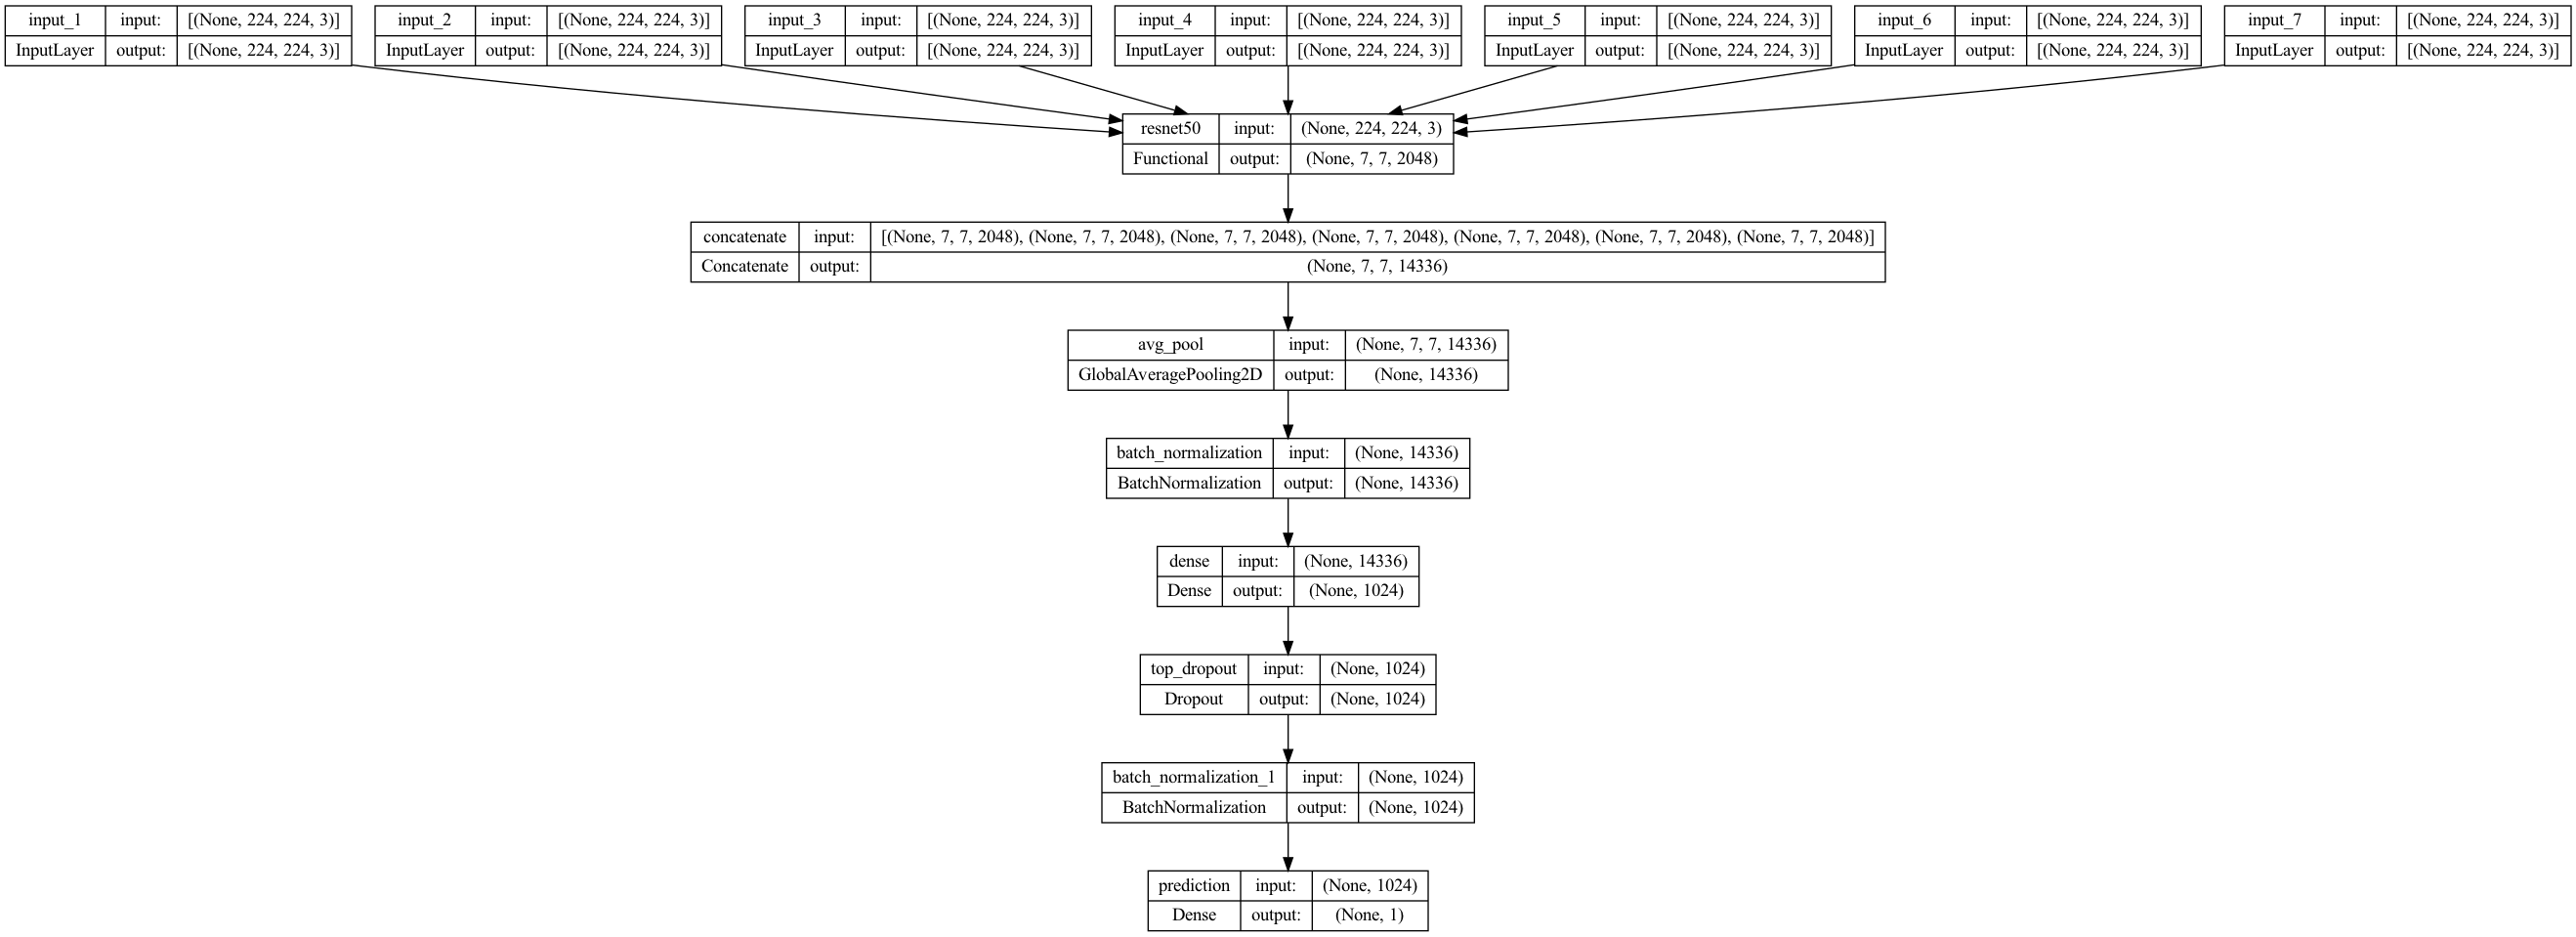

In [15]:
from keras.utils import plot_model
import pydot
from IPython.display import Image

# Display the image with a relative path
Image(filename='Method2.png')

### 3.3 Model Fitting
This step remains exactly the same as in method 1. Once again, Adam is utilized as a learning rate optimizer. Additionally, the Cyclical Learning Rate is implemented to ensure that the multi-input CNN does not get stuck in saddle points and local minima. Furthermore, the early stopping mechanism is implemented to prevent overfitting.

In [16]:
# Adding cyclical learning rate
from keras.callbacks import *
from clr_callback import CyclicLR
from keras.optimizers import Adam

#set the CLR options
clr_step_size = int(4 * (len(train_games)/batch_size))
base_lr = 1e-7
max_lr = 5e-2
mode='triangular'
clr_triangular = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=clr_step_size, mode=mode)
opt = Adam(0.0007)

# Adding an early stopping mechanism
EarlyStopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=1,
    verbose=1,
    start_from_epoch=3)

model.compile(optimizer=opt, loss='mean_absolute_error', metrics=[keras.metrics.MeanAbsoluteError()])
print("Model is compiled")

Model is compiled


The model is fitted using the same concepts as in method 1. Again, a limit of 6 epochs is set. Notably, the training of this model is significantly faster than the training of method 1. This is attributed to the fact that fewer steps needed to be performed, as the input now consists of rows with the games rather than rows with all of the screenshots.

In [17]:
# Fitting the model
history = model.fit(
    inputgenerator,
    steps_per_epoch=len(train_games)//batch_size,
    epochs=6,
    validation_data=valgenerator,
    validation_steps = len(val_games)//batch_size, 
    callbacks = [EarlyStopping_cb , clr_triangular]
)

Found 8766 validated image filenames.
Found 8766 validated image filenames.
Found 8766 validated image filenames.
Found 8766 validated image filenames.
Found 8766 validated image filenames.
Found 8766 validated image filenames.
Found 8766 validated image filenames.
Epoch 1/6


2024-05-24 01:13:34.167445: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


273/273 [==============================] - ETA: 0s - loss: 672.3126 - mean_absolute_error: 672.3126 Found 2922 validated image filenames.
Found 2922 validated image filenames.
Found 2922 validated image filenames.
Found 2922 validated image filenames.
Found 2922 validated image filenames.
Found 2921 validated image filenames.
Found 2922 validated image filenames.


/Users/sarahguilliams/anaconda3/lib/python3.11/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="5". These filename(s) will be ignored.
  warnings.warn(


273/273 [==============================] - 3725s 14s/step - loss: 672.3126 - mean_absolute_error: 672.3126 - val_loss: 620.4056 - val_mean_absolute_error: 620.4056
Epoch 2/6
273/273 [==============================] - 3792s 14s/step - loss: 592.1345 - mean_absolute_error: 592.1345 - val_loss: 599.4573 - val_mean_absolute_error: 599.4573
Epoch 3/6
273/273 [==============================] - 3822s 14s/step - loss: 589.7076 - mean_absolute_error: 589.7076 - val_loss: 658.6608 - val_mean_absolute_error: 658.6608
Epoch 4/6
273/273 [==============================] - 3800s 14s/step - loss: 593.8996 - mean_absolute_error: 593.8996 - val_loss: 624.5927 - val_mean_absolute_error: 624.5927
Epoch 5/6
273/273 [==============================] - 3774s 14s/step - loss: 590.8039 - mean_absolute_error: 590.8039 - val_loss: 619.9424 - val_mean_absolute_error: 619.9424
Epoch 6/6
273/273 [==============================] - 3787s 14s/step - loss: 589.6584 - mean_absolute_error: 589.6584 - val_loss: 602.5028 - 

The figure below illustrates the evolution of the training and validation MAE across the epochs. Similar to method 1, the training loss experienced a rapid decrease in the first epoch before stabilizing. The validation loss was relatively volatile during the training process, with a sharp increase during epoch 3. Afterwards, the validation loss decreased. Once again, from this visualization, one might get the impression that our learning rate is set too high. However, this argument might not hold due to the Cyclical Learning Rate.

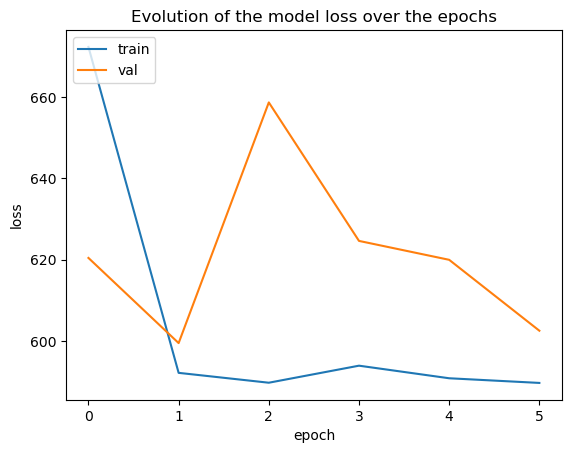

In [20]:
# Plotting the error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Evolution of the model loss over the epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 3.4 Model Evaluation
An evaluation of the multi-input CNN is performed. In contrast to method 1, this CNN now generates a single price for each video game. The resulting performance of this model is given by model.evaluate. The test set yielded a MAE of 609.06. Once again, this is still a relatively large error.

In [21]:
# Evaluate model
loss, mean_absolute_error = model.evaluate(testgenerator, steps=len(test_games)//batch_size)

Found 2923 validated image filenames.
Found 2923 validated image filenames.
Found 2923 validated image filenames.
Found 2923 validated image filenames.
Found 2923 validated image filenames.
Found 2923 validated image filenames.
Found 2923 validated image filenames.
91/91 [==============================] - 849s 9s/step - loss: 609.0604 - mean_absolute_error: 609.0604


Again, we predict the prices of the video games to further analyze what causes the large error. This can be done by first making the predictions on the (normalized) inputs. In comparison to method 1, the model now needs 7 inputs to make a prediction. These 7 inputs are accessed by extracting the first 7 screenshots from the test dataframe. 

In [23]:
pred = []

for i in range(len(test_games)):

    image_paths = [os.path.join(image_location, filename) for filename in test_games.iloc[i, 1:8]]
    images = [keras.utils.load_img(image_path, target_size=(224, 224)) for image_path in image_paths]

    img_arrays = [keras.utils.img_to_array(img) for img in images]
    img_arrays = [img_array / 255.0 for img_array in img_arrays]
    img_arrays = [tf.expand_dims(img_array, 0) for img_array in img_arrays]  # Create batch axis for each image


    predictions = model.predict(img_arrays, verbose=0)
    price_difference = predictions[0][0] - test_games.iloc[i]['price']
    pred.append({'price': predictions[0][0], 'difference': price_difference})
    #print('prediction ', i , predictions[0][0] , 'Difference:', price_difference)

predictions_test = pd.DataFrame(pred)
predictions_test.head()

price  difference
0  372.337952 -602.662048
1  393.042236 -295.957764
2  342.153931 -836.846069
3  418.475800  219.475800
4  394.423065   -4.576935

Next, we plot the predicted price vs the actual price. Once again, the model struggles to make predictions for higher prices. Moreover, it appears that the highest price that the model is able to predict is around 1000¢. This indicates that the model is still not performing as well as desired.

Text(0.5, 0, 'Actual')

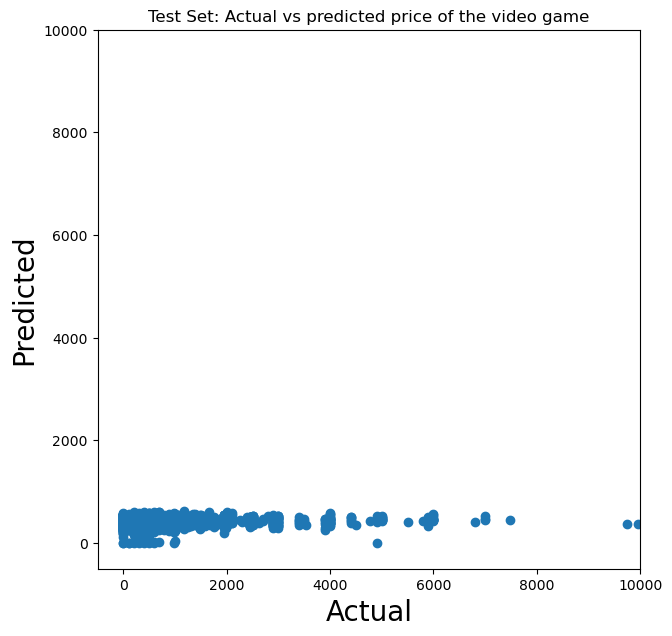

In [26]:
plt.figure(figsize = (7,7))
plt.axis([-500, 10000, -500, 10000])
plt.scatter(test_games['price'], predictions_test['price'])

plt.title("Test Set: Actual vs predicted price of the video game")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)

Below, some evaluation metrics are generated. These indicate that the model is not performing well. These evaluation metrics can be compared to the metrics of method 3 to determine which method has the best performance. 

In [27]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_games['price'], predictions_test['price']))
print('Mean Squared Error:', metrics.mean_squared_error(test_games['price'], predictions_test['price']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_games['price'], predictions_test['price'])))
print('R2 score:', metrics.r2_score(test_games['price'], predictions_test['price']))

Mean Absolute Error: 608.8435339534524
Mean Squared Error: 1111221.9751226068
Root Mean Squared Error: 1054.145139495794
R2 score: -0.14323989074025834


When we plot a histogram showing the distribution of the differences between the predicted price and the actual price, we can observe that the majority of the differences are centered 0. This suggests that the model can predict the majority of the games relatively well. However, the distribution is still skewed indicating that the model tends to underestimate the prices of the video games.

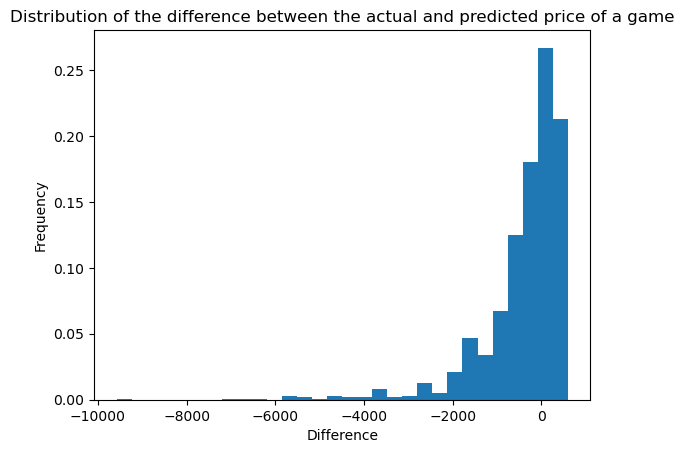

In [28]:
# Plot histogram of the differences in price
plt.hist(predictions_test['difference'], weights=np.zeros_like(predictions_test['difference']) + 1. / predictions_test['difference'].size, bins=30)

# Add labels and title
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Distribution of the difference between the actual and predicted price of a game')

# Show plot
plt.show()

### 3.5 Predictions
As a final section on the multi-input CNN, an illustration of the model's prediction is provided for an example game. Below, the 7 images that are used as inputs of the CNN are illustrated, along with the predicted price.

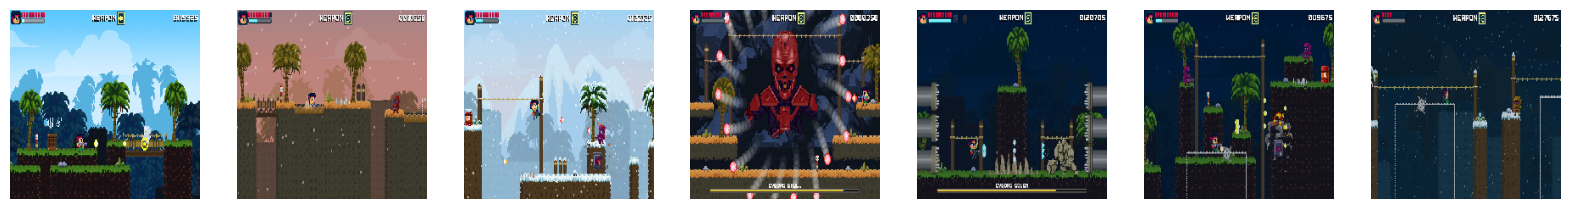

Predicted game price: 375.4889221191406
Actual game price: 198


In [35]:
game_id = 101
game = test_games.iloc[game_id]

# Load the images
image_paths = [os.path.join(image_location, filename) for filename in game.iloc[1:8]]
images = [keras.utils.load_img(image_path, target_size=(224, 224)) for image_path in image_paths]

# Prepare the images for the model
img_arrays = [keras.utils.img_to_array(img) for img in images]
img_arrays = [img_array / 255.0 for img_array in img_arrays]
img_arrays = [tf.expand_dims(img_array, 0) for img_array in img_arrays] 

# Make predictions
predictions = model.predict(img_arrays, verbose=0)
predicted_price = predictions[0][0]
actual_price = game['price']

# Display the images in a 1x7 grid with predicted and actual prices
plt.figure(figsize=(20, 5))
for idx, img in enumerate(images):
    plt.subplot(1, 7, idx+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Print the prediction and difference
print(f'Predicted game price: {predicted_price}')
print(f'Actual game price: {actual_price}')

Note that this section will not include the interpretability analysis of the model using saliency plots, as the tf-keras-vis package does not support multi-input CNNs.

## 4. Method 3: Stitched Images

The final method involves developing a CNN to predict the price of a video game using a single input image. Unlike method 1, which used individual screenshots, this method used a stitched image composed of all the screenshots for a given video game. The image below illustrates an example of such a stitched image.

When stitching the images together, a new dataframe was generated with one column containing the game price and one column containing the name of the new image. Therefore, all preprocessing steps, such as the train test split, needed to be performed once more.

In [6]:
#read in dataframe that contains the name of the first screenshot used in the stitching of the images and the price of the game. 
df = pd.read_csv('stitched_price.csv')

image_location = 'D:/images/stitched'

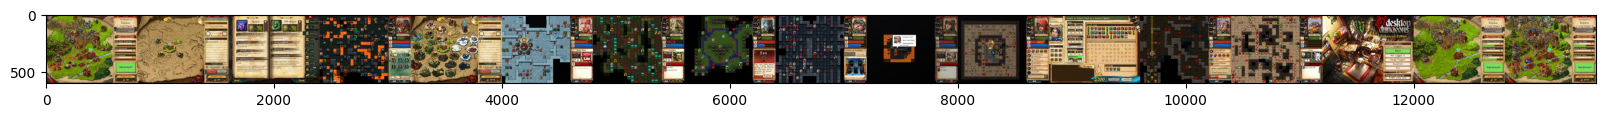

In [7]:
import matplotlib.image as mpimg

image_path = 'D:/images/stitched/226620_ss_08d910d405bfbdd6a5b81f69a4f9b85a66cb0bc5.1920x1080.jpg'  

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.figure(figsize=(20,7))
plt.imshow(img)
plt.show()

### 4.1 Preprocessing

#### 4.1.1 Removal of Outliers

 Because of the new dataframe, all preprocessing has to be repeated. Again, all games with prices above 10000¢ are removed from the dataset.

In [8]:
# Select a portion of the games. If we want to train on all of the data, set it equal to 1.
num_selected_games = int(len(df))
np.random.seed(0) #This is so that we get the same games when training the model.
selected_games = df.sample(n=num_selected_games)

In [9]:
# Remove the games that have a price larger than 100 USD from selected games
selected_games_no_outliers = selected_games[selected_games['price'] <= 10000]
# The dataset also includes 'bundle' games. these bundles contain multiple games. They have a very high price. As they are not in the scope of this model they are removed.

#### 4.1.2 Train Test Split

Also, the train test split needed to be performed again due to the new dataframe.

In [10]:
# Train test split
from sklearn.model_selection import train_test_split
# Split data into training and validation sets based on games
train1_games, test_games = train_test_split(selected_games_no_outliers, test_size=0.2, random_state=42) 
train_games, val_games = train_test_split(train1_games, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

In [11]:
val_games['price'] = val_games['price'].astype('float32')
test_games['price'] = test_games['price'].astype('float32')
train_games['price'] =train_games['price'].astype('float32')

In [12]:
train_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8780 entries, 13619 to 1980
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   screenshot  8780 non-null   object 
 1   price       8780 non-null   float32
dtypes: float32(1), object(1)
memory usage: 171.5+ KB


#### 4.1.3 Normalization and Image Augmentation

Similar to method 1 and 2, the ImageDataGenerator is used for normalization and image augmentation. 

In [13]:
#create a training datagenerator, including data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, 
                                                                        rotation_range=45, horizontal_flip=True, vertical_flip=True)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_games, directory=image_location, 
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(224, 224), 
                                              batch_size=32)



# same for the test set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

val_generator = test_datagen.flow_from_dataframe(dataframe=val_games, directory=image_location, 
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(224, 224), 
                                              batch_size=32)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_games, directory=image_location, 
                                              x_col="screenshot", y_col="price", has_ext=True, 
                                              class_mode="other", target_size=(224, 224), 
                                              batch_size=32)


Found 8780 validated image filenames.
Found 2927 validated image filenames.
Found 2927 validated image filenames.


### 4.2 Model Architecture

Again, the model is built on the transfer learning principle and by adding additional layers on top of the pre-trained network.

Similar to method 1 and 2, a pre-trained ResNet50 model from the Keras library is used.
This model expects a 224x224 image. Because the images are stitched together, they will end up being greatly deformed. This might make it harder for the model to extract features and make good predictions. 

On top of the ResNet50 model, a convolutional layer is added to filter more features from the images. Additionally, Maxpooling is used to downsample. Several attempts have been made to add more convolutional layers. However this was not possible as problems with the shape of the image size arose. Later, a Dropout layer is added to prevent overfitting. The flatten layer maps the 2D vectors to a 1D vector. The dense layers connect the features to one continuous output.

In [14]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import layers

inputs= layers.Input(shape=(224, 224, 3))

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=inputs, input_shape=(224,224, 3))

In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

# Freeze the base model
base_model.trainable = False

# Add layers to the base model
model = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu', padding = "same", input_shape=(224,224, 3)), #add multiple convolution layers
    MaxPooling2D((2, 2)),
    # Conv2D(32, (3, 3), activation='relu', padding = "same"),
    # MaxPooling2D((2, 2)),
    # Conv2D(32, (3, 3), activation='relu', padding = "same"),
    # MaxPooling2D((2, 2)),
    Dropout(0.20),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

c:\Users\Laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Below, an illustration is given of the architecture of the CNN developed for method 3. 

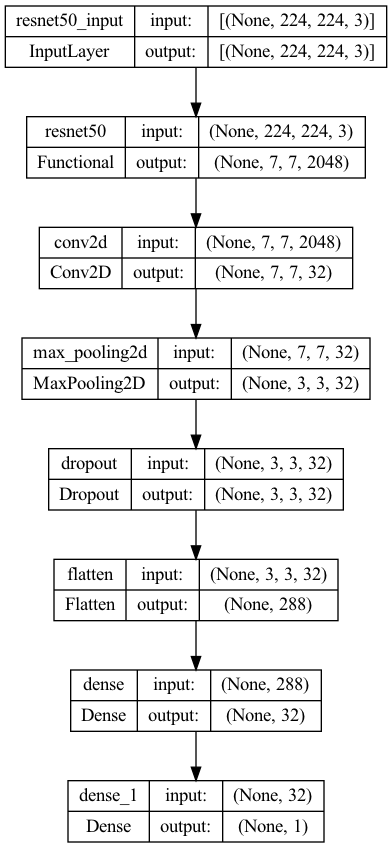

In [16]:
from keras.utils import plot_model
from IPython.display import Image

# Display the image with a relative path
Image(filename='Method3.png')

It should be noted that a small problem occurred, which is visible in the summary of the model printed below. It seems that there are a lot more untrainable parameters than trainable. Adding additional convolutional layers would increase this number of untrainable parameters. However, one extra layer could be added. This did not improve the model. More layers could not be added as it conflicted with the input shape.

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,385,125 (96.84 MB)

 Trainable params: 599,137 (2.29 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,198,276 (4.57 MB)

### 4.3 Model Fitting

Finally, the model is compiled and fitted. The loss function is based on the mean squared error. Other loss functions such as the mean absolute error, mean squared logarithmic error and Huber were tried, but did not result in improvements of the performance. 5 epochs were used to train the CNN.

In [19]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    epochs=5, 
    validation_data=val_generator,
    validation_steps=val_generator.n//batch_size
)


Epoch 1/5


c:\Users\Laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


274/274 ━━━━━━━━━━━━━━━━━━━━ 1868s 7s/step - loss: 1094785.0000 - mae: 676.4563 - val_loss: 974681.1250 - val_mae: 674.2493
Epoch 2/5
  1/274 ━━━━━━━━━━━━━━━━━━━━ 8:08 2s/step - loss: 1936508.6250 - mae: 937.0500

c:\Users\Laure\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 971788.0625 - mae: 937.0500 - val_loss: 158141.7188 - val_mae: 492.6329
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 1564s 6s/step - loss: 893289.5625 - mae: 636.4132 - val_loss: 961198.3125 - val_mae: 660.8182
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 177961.2500 - mae: 529.0148 - val_loss: 702724.8125 - val_mae: 809.7452
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 1636s 6s/step - loss: 1000442.8750 - mae: 663.0811 - val_loss: 959050.4375 - val_mae: 634.5232


The figure below shows the evolution of the training and validation loss across 5 epochs. The input ran out of data during the second epoch, because during the fitting of the model the batch size was probably not taken into account properly. So only 4 epochs gave useful results. This explains the high training loss of the model during the second epoch.

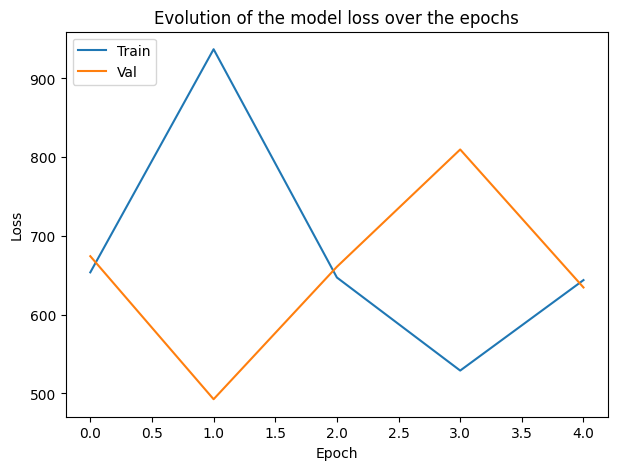

In [20]:
plt.figure(figsize=(7,5))
# Plotting the error
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Evolution of the model loss over the epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

### 4.4 Model Evaluation

In [21]:
# Evaluate model
loss, mae = model.evaluate(test_generator)
print("Validation Mean Absolute Error:", mae)

# Save the model
model.save("fullModel_5epochs.keras")

92/92 ━━━━━━━━━━━━━━━━━━━━ 425s 5s/step - loss: 930254.9375 - mae: 638.5538
Validation Mean Absolute Error: 633.0514526367188


The following part predicts the price for each stitched image in the test set. Later, some metrics are calculated and a graph is plotted. Based on these it is clear the model does not function properly. It is not clear why the model only predicts in a very limited interval. A possible explanation is the high density of games with a price in the predicted interval. When looking at the plot with the difference between predicted and real value. It's shown that 51% of the values have a lower absolute difference than 500¢ (5 USD). It is possible that based on the loss functions, this is the optimal way for the model to minimize the loss function.
<br>
Several attempts were made to create a better model. The following concepts were tried but did not generate better predictions:
- Duplicating images to get an equal image width. By having an equal width over all inputs could have made it easier for the model to extract features and apply it on images with the same shape.
- Transforming the regression problem into a classification problem with 'price ranges', combined with over/undersampling.
- Logtransformation of the prices because of the right skewed 'price' distribution

In [22]:
# model = keras.models.load_model("fullModel_5epochs.keras") #Load in trained model

pred = []

for i in range(len(test_games)):
    filename = test_games.iloc[i]["screenshot"]
    image_path = os.path.join(image_location, filename)
    img = keras.utils.load_img(image_path, target_size=(224, 224))


    img_array = keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image data
    img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array, verbose=0)

    price_difference = predictions[0][0] - test_games.iloc[i]['price']
    pred.append({'price': predictions[0][0], 'difference': price_difference})
    #print('difference ', i , predictions[0][0] - test_games.iloc[i]["price"])

predictions_test = pd.DataFrame(pred)

In [23]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_games['price'], predictions_test['price']))
print('Mean Squared Error:', metrics.mean_squared_error(test_games['price'], predictions_test['price']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_games['price'], predictions_test['price'])))
print('R2 score:', metrics.r2_score(test_games['price'], predictions_test['price']))
print('Mean absolute percentage error:', metrics.mean_absolute_percentage_error(test_games['price'], predictions_test['price']))

Mean Absolute Error: 633.05164
Mean Squared Error: 953572.25
Root Mean Squared Error: 976.51025
R2 score: 0.02255694476104564
Mean absolute percentage error: 5.557571e+17


Text(0.5, 0, 'Actual')

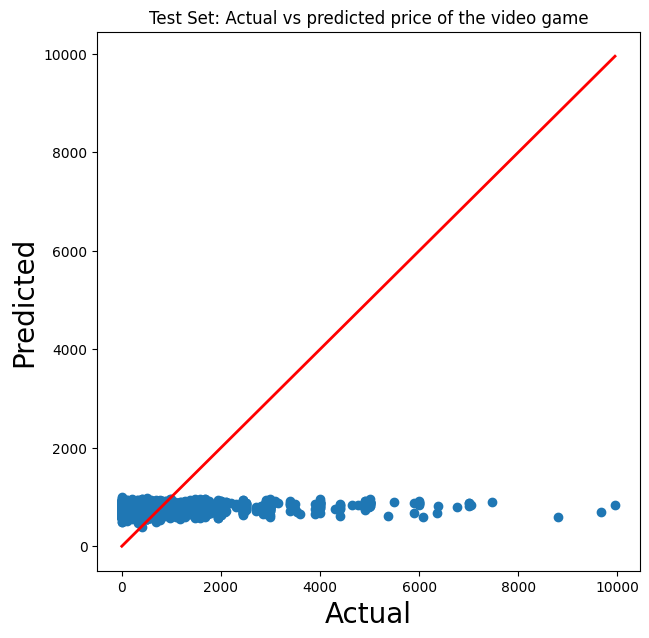

In [24]:
# plot the predicted vs actual values
plt.figure(figsize = (7,7))
plt.scatter(test_games['price'], predictions_test['price'])
plt.plot([min(test_games['price']), max(test_games['price'])], [min(test_games['price']), max(test_games['price'])], color="r", linestyle="-", linewidth=2)
plt.title("Test Set: Actual vs predicted price of the video game")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)

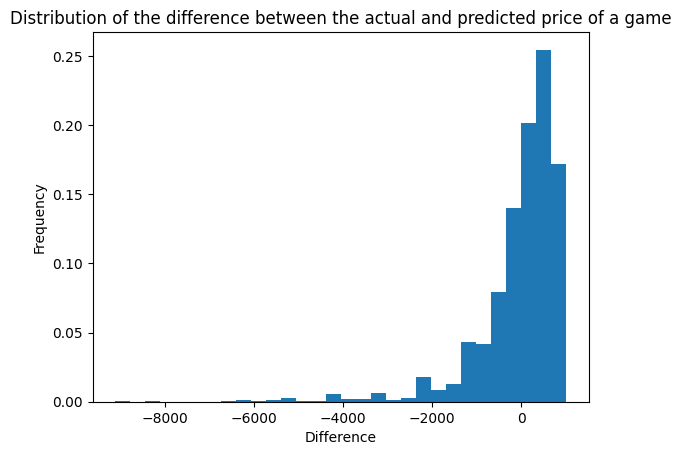

In [32]:
# Plot histogram of the differences in price
plt.hist(predictions_test['difference'], weights=np.zeros_like(predictions_test['difference']) + 1. / predictions_test['difference'].size, bins=30)

# Add labels and title
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Distribution of the difference between the actual and predicted price of a game')

# Show plot
plt.show()

In [45]:
# Define the threshold
threshold = 500.0

# Calculate the percentage
total_values = predictions_test['difference'].count()

# Count the number of values in the interval
predictions_test['difference'] = predictions_test['difference'][predictions_test['difference'] <= threshold]
predictions_test['difference'] = predictions_test['difference'][predictions_test['difference'] >= -threshold]

count = predictions_test['difference'].count()

percentage_lower = (count / total_values) * 100

print(f'Number of values in the interval ({-threshold},{threshold} ): {count}')
print(f'Percentage of values in the interval ({-threshold},{threshold} ): {percentage_lower:.2f}%')

Number of values in the interval (-500.0,500.0 ): 1501
Percentage of values in the interval (-500.0,500.0 ): 51.28%


### 4.5 Predictions

Next, predictions for two images are illustrated.

predicted price:  669.5873
real price:  199.0


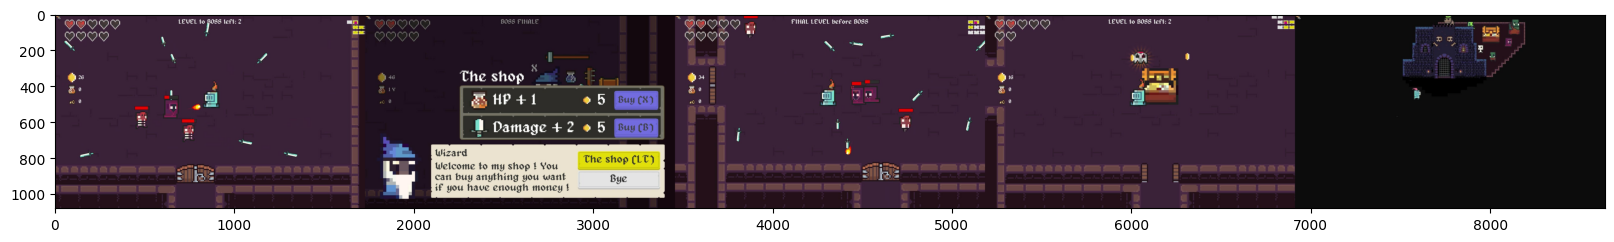

In [30]:
#show third prediction
filename = test_games.iloc[2]["screenshot"]
image_path = os.path.join(image_location, filename)
img = keras.utils.load_img(image_path, target_size=(224, 224))


img_array = keras.utils.img_to_array(img)
img_array = img_array / 255.0  # Normalize the image data
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array, verbose=0)

print('predicted price: ', predictions[0][0])
print('real price: ', test_games.iloc[2]["price"])

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.figure(figsize=(20,7))
plt.imshow(img)
plt.show()

predicted price:  649.11066
real price:  499.0


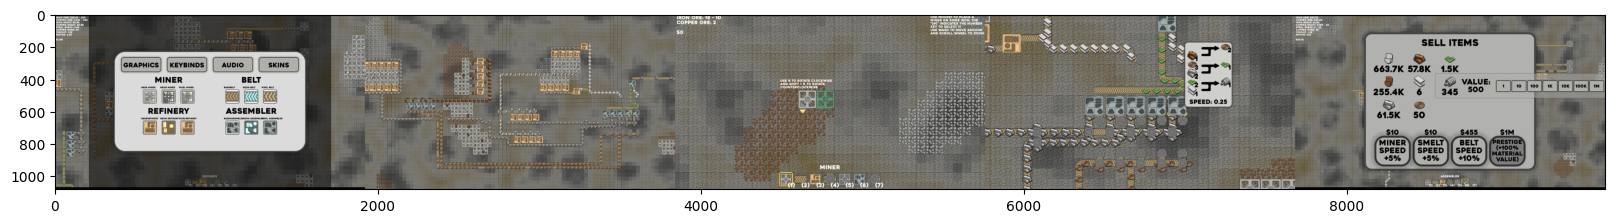

In [26]:
#show second prediction
filename = test_games.iloc[1]["screenshot"]
image_path = os.path.join(image_location, filename)
img = keras.utils.load_img(image_path, target_size=(224, 224))


img_array = keras.utils.img_to_array(img)
img_array = img_array / 255.0  # Normalize the image data
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array, verbose=0)

print('predicted price: ', predictions[0][0])
print('real price: ', test_games.iloc[1]["price"])

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.figure(figsize=(20,7))
plt.imshow(img)
plt.show()

### 4.6 Model interpretability

A saliency map is added for interpretability. No insights can be extracted from these as no clear trends can be seen to explain the bad predictions. This technique is harder to apply here as the images are deformed. 

D:/images/stitched\2524150_ss_0f5f5cc251df3b0f60883ba54d0c548d0c425e5d.1920x1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
747


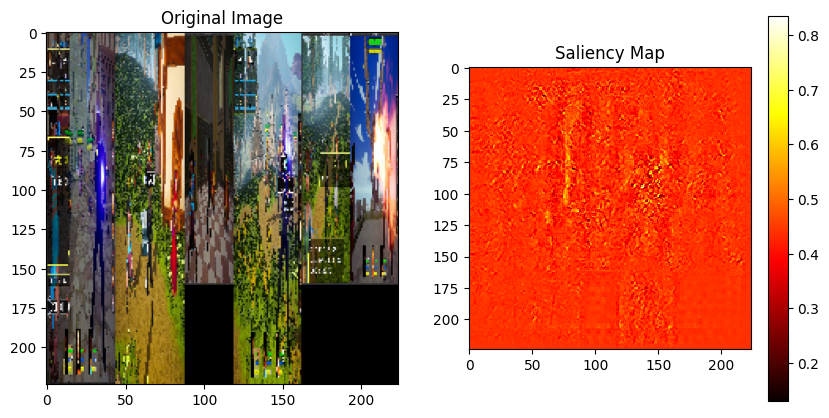

In [28]:
from tensorflow.keras.preprocessing import image

filename = test_games.iloc[10]["screenshot"]
img_path = os.path.join(image_location, filename)
print(img_path)
img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size as per your model's input


img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalization if required by your model

# Make a prediction
predictions = model.predict(img_array)
predicted_class = int(predictions[0][0])
print(predicted_class)
img_tensor = tf.convert_to_tensor(img_array)

# Compute the gradient of the output with respect to the input image
with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    predictions = model(img_tensor)
    # For regression, assume predictions is a scalar value
    loss = predictions[0]

grads = tape.gradient(loss, img_tensor)
grads = tf.reduce_mean(grads, axis=0)

# Process the gradients to generate the saliency map
grad_max = tf.reduce_max(grads)
grad_min = tf.reduce_min(grads)
grads = (grads - grad_min) / (grad_max - grad_min)  # Normalize between 0 and 1
grads = tf.clip_by_value(grads, 0, 1)  # Clip values to [0, 1] range

# Convert to numpy array for visualization
grads = grads.numpy()
saliency_map = np.mean(grads, axis=-1)

# Plot the original image and the saliency map
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("Saliency Map")
plt.imshow(saliency_map, cmap='hot', interpolation='nearest')
plt.colorbar()

plt.show()

## 5. Conclusion
In this assignment, we used video game images to predict their prices. To do this we proposed 3 methodologies. The first methodology resulted in the highest MAE. However, this approach evaluated performance based on all images without accounting for images belonging to the same game, which might not provide an accurate measure of predictive accuracy.

A correct comparison in performance can be done between method 2 and method 3, as both models were evaluated based on their ability to predict the price of a game as a whole. In the end, we can conclude that, based on the MAE, method 2 performs better. The difference is very small and both models seem to make the same mistake of predicting only inside a limited interval.

Despite the improved performance, it must be explicitly mentioned that the overall performance of the model is still not satisfactory. One explanation for this could be that the CNN is not adequately calibrated or fitted to the data. Alternatively, it might simply be that distinguishing between cheap and expensive games based on images alone is inherently challenging. Unlike identifying a game's genre, even humans might find it nearly impossible to determine the price just from the images. Other features such as multiplayer, cross-console, hype also determine the price of a game. Only the graphics of the game might not be enough to predict the price. This limitation must be taken into consideration when evaluating the performance of the models.

We also propose some next steps that might improve the models' performance, which we did not implement due to limited computational power. Several examples online suggest unfreezing more layers than just the last layer of the pre-trained model and fine-tuning the weights of these additional layers (https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/). It would be interesting to explore whether this approach could enhance the models' performance.